# Plots for Siggi Paper

### Simple examples of information gain

In [1]:
# First import code
import sys
sys.path.append('..')

In [2]:
from siggi import siggi, filters, spectra, calcIG, plotting
from siggi import Sed
from siggi.lsst_utils import Bandpass, BandpassDict
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import seaborn as sbs
sbs.set()

### Set up red and blue spectra

In [4]:
f = filters()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

In [5]:
def flat_prior_2(z):
    return 0.5

In [6]:
sig_example = siggi([red_spec, blue_spec], [0.5, 0.5], flat_prior_2,
                    z_min=0.0, z_max=0.0, z_steps=1)

In [7]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [9]:
%%time
test_rand_state = np.random.RandomState(42)
num_filters = 2
set_ratio = 0.5
res = sig_example.optimize_filters(num_filters=num_filters,
                                   filt_min=300., filt_max=1100.,
                                   set_ratio=set_ratio,
                                   system_wavelen_max=1200.,
                                   n_opt_points=15,
                                   optimizer_verbosity=5,
                                   procs=8, 
                                   frozen_filt_dict = None,
                                   starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list],
                                   rand_state=test_rand_state)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   31.5s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   52.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 758 out of 758 | elapsed:  2.3min finished


-1.0 758
CPU times: user 1min 54s, sys: 15.1 s, total: 2min 9s
Wall time: 4min 1s


##### Providing a random seed introduces reproducibility as long as the same number of processors are used in parallelization.

In [89]:
%%time
test_rand_state = np.random.RandomState(42)
num_filters = 2
set_ratio = 0.5
res = sig_example.optimize_filters(num_filters=num_filters,
                                   filt_min=300., filt_max=1100.,
                                   sed_mags=22.0,
                                   set_ratio=set_ratio,
                                   system_wavelen_max=1200.,
                                   n_opt_points=15,
                                   optimizer_verbosity=5,
                                   procs=8,
                                   frozen_filt_dict = None,
                                   starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list],
                                   rand_state=test_rand_state)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   12.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   33.4s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 758 out of 758 | elapsed:  3.0min finished


-0.9979461713935753 758
CPU times: user 2min 8s, sys: 19.2 s, total: 2min 27s
Wall time: 5min 15s


### Make plots

In [10]:
min_idx = np.argmin(res.yi[:-3])

best_pt = res.Xi[min_idx]

In [11]:
best_val = res.yi[min_idx]

In [12]:
print(best_pt, best_val)

[725.0, 825.0, 400.0, 500.0] -0.9999999999999998


In [13]:
best_pt = [best_pt[2], best_pt[3], best_pt[0], best_pt[1]]

In [14]:
sig_plot = plotting([red_spec, blue_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

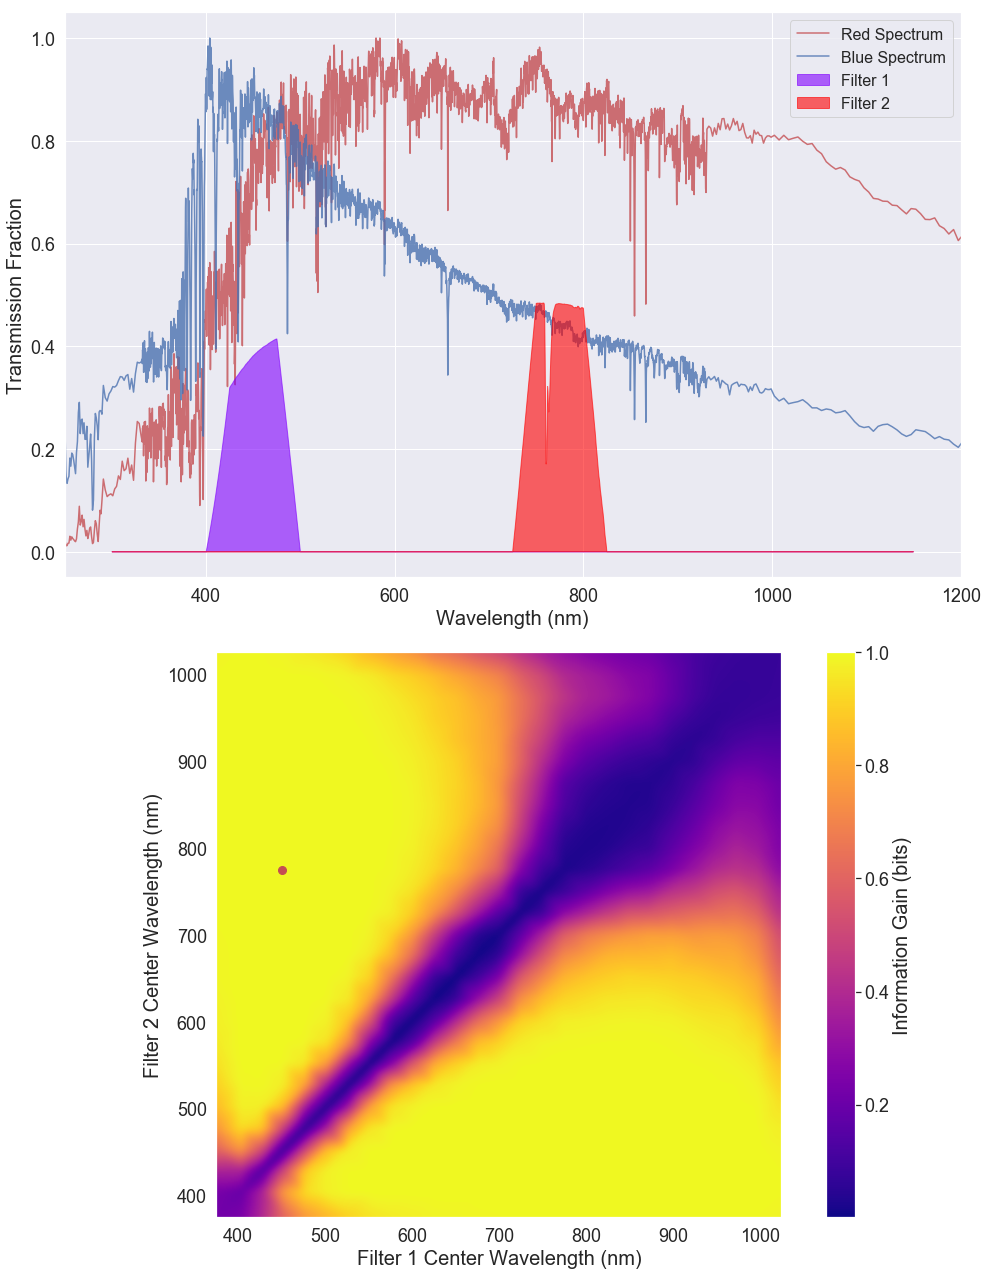

In [15]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax.lines[0].set_color('r')
ax.lines[1].set_color('b')
ax.lines[0].set_alpha(0.8)
ax.lines[1].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Red Spectrum', 'Blue Spectrum', 'Filter 1', 'Filter 2'), loc=1, fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res.Xi[:-3], np.abs(res.yi[:-3]), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=64)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_1.pdf')

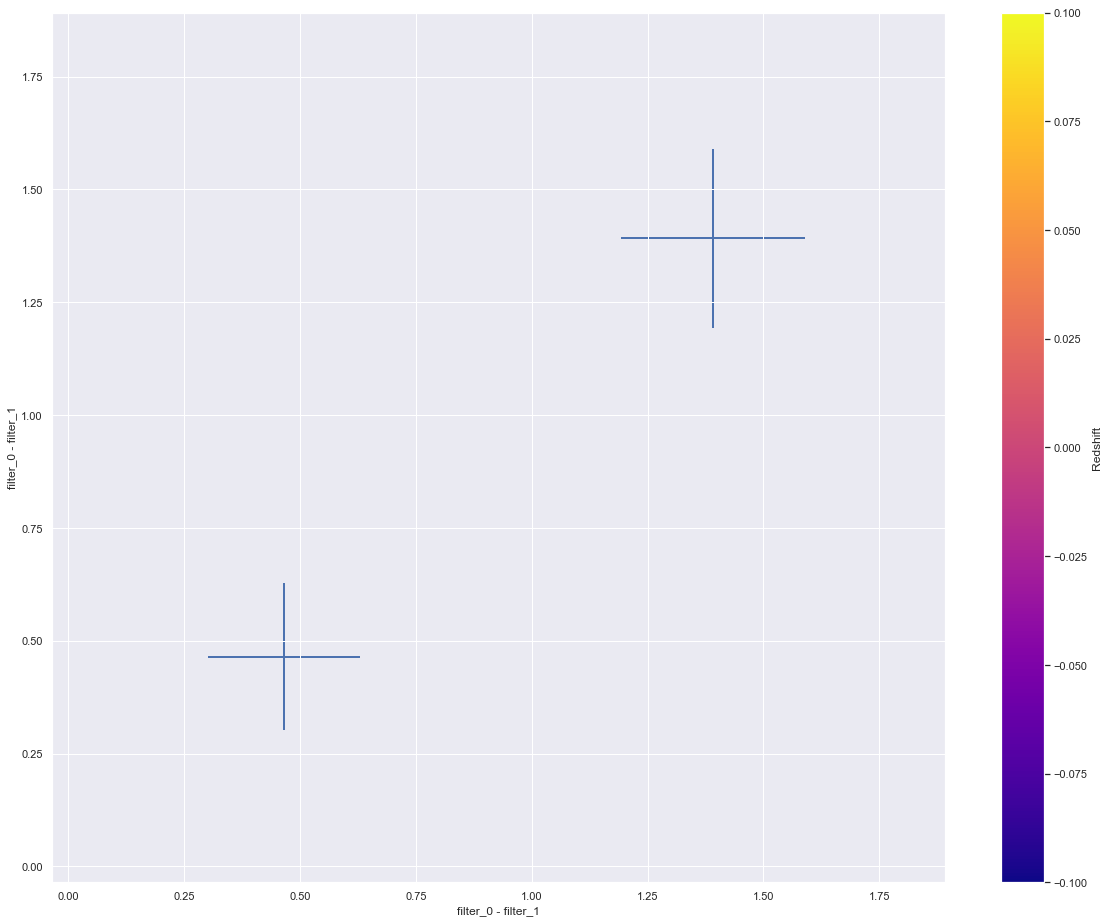

In [16]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                                np.linspace(0.00, 0.0), fig=fig)

In [17]:
sig_plot.filter_dict.magListForSed(blue_spec), sig_plot.filter_dict.magListForSed(red_spec)

(array([-18.28724672, -18.76271467]), array([-18.07380827, -19.49685499]))

### Make sigmoid filter plot

In [18]:
sig_spec = s.get_sigmoid_spectrum()

In [19]:
sig_spec.wavelen[np.where(sig_spec.flambda < 0.01)] = 0.01

In [20]:
def prior_z(z, z0=0.5):
    return (z**2.)*np.exp(-(z/z0)**1.5)/(np.sum((np.arange(0, 2.51, .05)**2.)*np.exp(-(np.arange(0, 2.51, .05)/z0)**1.5)))

Text(0,0.5,'Prior Probability')

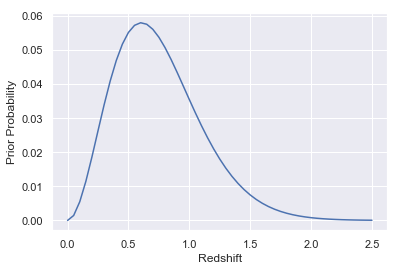

In [21]:
plt.plot(np.arange(0.00, 2.51, 0.05), prior_z(np.arange(0.00, 2.51, 0.05)))
plt.xlabel('Redshift')
plt.ylabel('Prior Probability')

(200, 500)

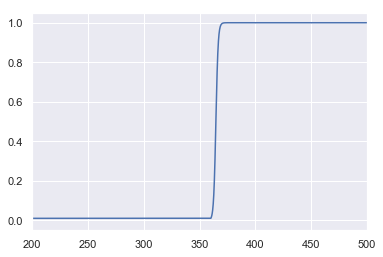

In [22]:
plt.plot(sig_spec.wavelen, sig_spec.flambda)
plt.xlim(200, 500)

In [23]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [24]:
ref_filter = Bandpass()
ref_filter.imsimBandpass()

In [25]:
sig_example = siggi([sig_spec], [1.0], prior_z,# calib_filter=ref_filter,
                    z_min=0.05, z_max=2.5, z_steps=50)

In [116]:
%%time
test_rand_state = np.random.RandomState(2325)
num_filters = 2
set_ratio = 0.5
res_2 = sig_example.optimize_filters(num_filters=num_filters,
                                     filt_min=300., filt_max=1100.,
                                     set_ratio=set_ratio,
                                     system_wavelen_max=1200.,
                                     n_opt_points=15,
                                     optimizer_verbosity=5,
                                     procs=8, acq_func_kwargs_dict={'kappa':1.8},
                                     frozen_filt_dict = None,
                                     starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list],
                                     rand_state=test_rand_state)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   42.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 758 out of 758 | elapsed:  8.8min finished


-3.1408969050740843 758
CPU times: user 2min 17s, sys: 48.4 s, total: 3min 6s
Wall time: 10min 46s


In [140]:
min_idx = np.argmin(res_2.yi[:-3])
best_pt = res_2.Xi[min_idx]
print(best_pt, res_2.yi[min_idx])

[725.0, 825.0, 525.0, 625.0] -2.177922003177988


In [141]:
best_pt = [best_pt[2], best_pt[3], best_pt[0], best_pt[1]]

In [142]:
sig_spec.redshiftSED(0.6)
sig_plot = plotting([sig_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

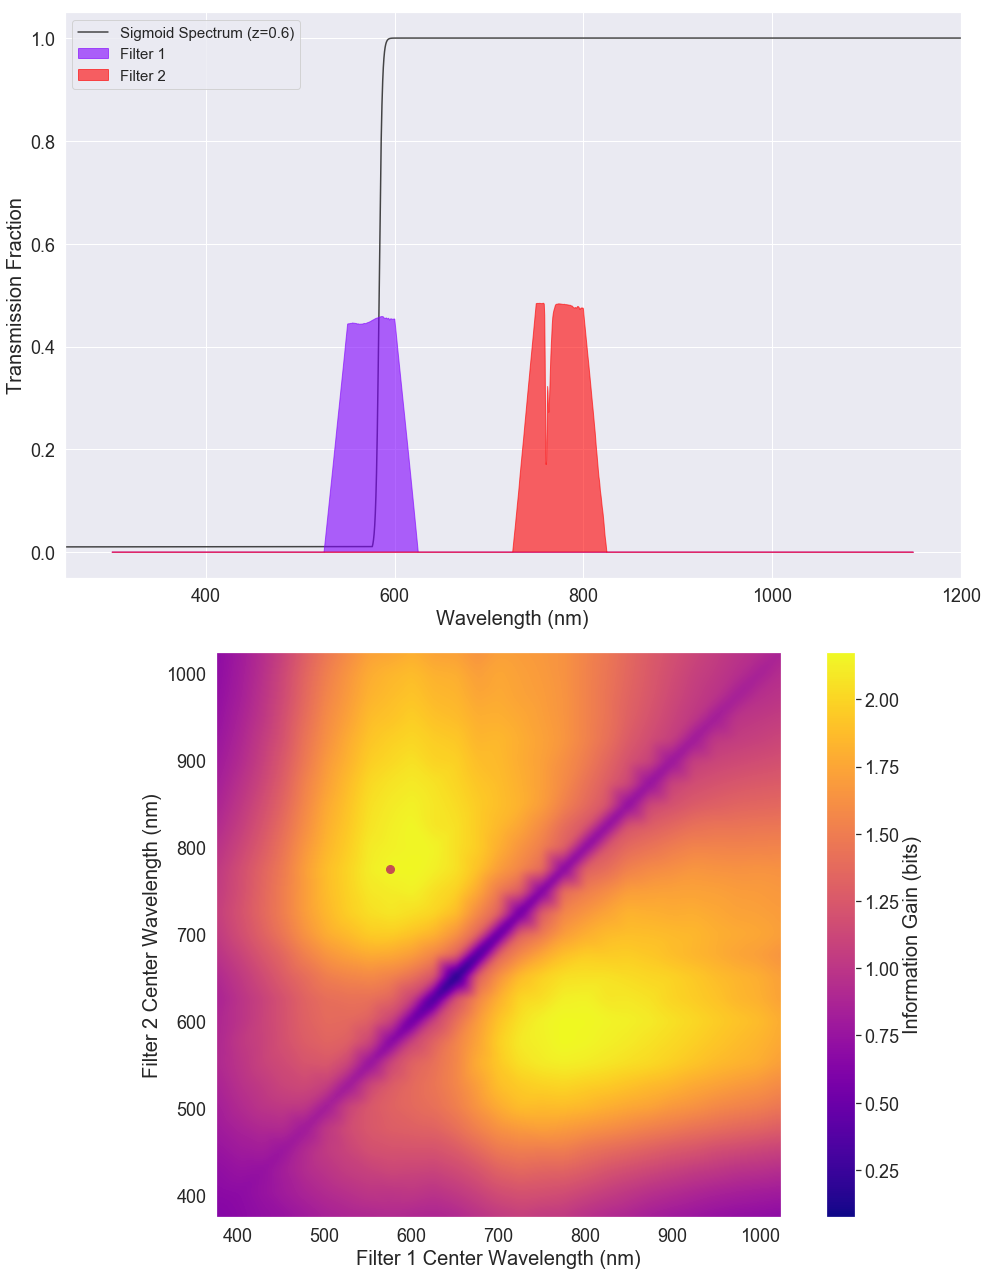

In [143]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax.lines[0].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Sigmoid Spectrum (z=0.6)', 'Filter 1', 'Filter 2'), loc=2, fontsize=15)
plt.xticks(size=18)
plt.yticks(size=18)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res_2.Xi[:-3], np.abs(res_2.yi[:-3]), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=64)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_2.pdf')

## Example 3

In [28]:
red_spec = s.get_red_spectrum()

In [29]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [30]:
sig_example = siggi([red_spec], [1.0], prior_z,
                    z_min=0.05, z_max=2.5, z_steps=50)

In [31]:
%%time
test_rand_state = np.random.RandomState(864)
num_filters = 2
set_ratio = 0.5
res_3 = sig_example.optimize_filters(num_filters=num_filters,
                                     filt_min=300., filt_max=1100.,
                                     sed_mags=22.0,
                                     set_ratio=set_ratio,
                                     system_wavelen_max=1200.,
                                     n_opt_points=15,
                                     optimizer_verbosity=5,
                                     procs=8,
                                     frozen_filt_dict = None,
                                     starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list],
                                     rand_state=test_rand_state)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   51.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 758 out of 758 | elapsed:  4.1min finished


-2.5865490900540618 758
CPU times: user 2min 5s, sys: 21.4 s, total: 2min 26s
Wall time: 5min 54s


In [32]:
min_idx = np.argmin(res_3.yi[:-3])
best_pt = res_3.Xi[min_idx]
print(best_pt, res_3.yi[min_idx])

[625.0, 725.0, 925.0, 1025.0] -2.4941933305771204


In [145]:
# Uncomment if blue and red filters are reversed
#best_pt = [best_pt[2], best_pt[3], best_pt[0], best_pt[1]]

In [33]:
#blue_spec.redshiftSED(0.6)
sig_plot = plotting([red_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

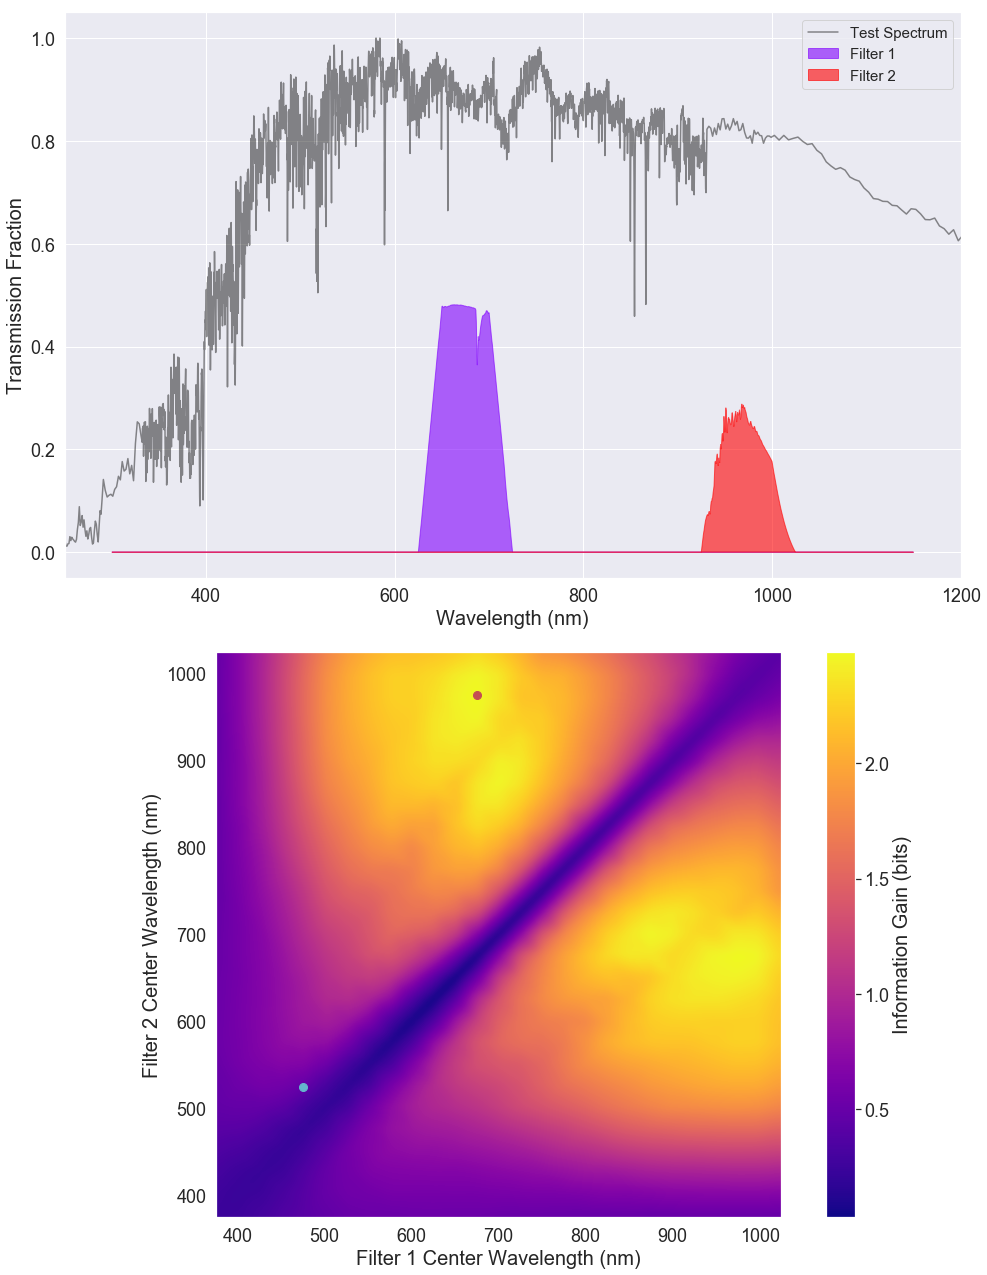

In [34]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Test Spectrum', 'Filter 1', 'Filter 2'), loc=1, fontsize=15)
plt.xticks(size=18)
plt.yticks(size=18)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res_3.Xi[:-3], np.abs(res_3.yi[:-3]), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=64)
plt.scatter(475., 525., c='c', s=64)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_3.pdf')

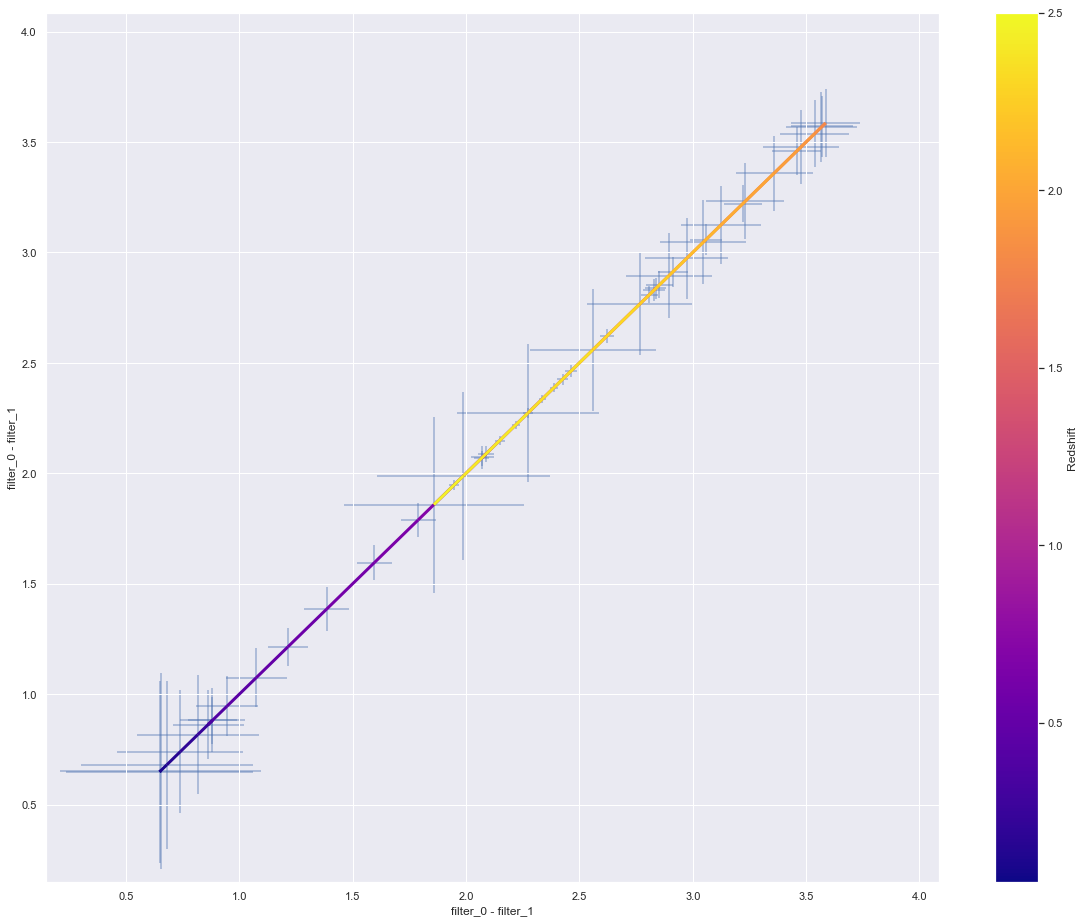

In [35]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                                np.linspace(0.05, 2.5, 50), fig=fig)

In [107]:
    def get_color_color(sig_plot_obj, filter_names, redshift_list,
                         cmap=plt.get_cmap('plasma'), fig=None,
                         include_err=True, cbar=False, y_label=False):

        """
        Plot the color-color tracks for each SED template as a function
        of redshift using pairs of filters.
        """

        if fig is None:
            fig = plt.figure(figsize=(12, 6))

        shift_seds = []

        for sed_obj in sig_plot_obj.sed_list:
            for z_val in redshift_list:
                sed_copy = deepcopy(sed_obj)
                sed_copy.redshiftSED(z_val)
                shift_seds.append(sed_copy)

        color_x_dict = BandpassDict([sig_plot_obj.filter_dict[filt] for filt
                                     in filter_names[:2]], filter_names[:2])
        color_y_dict = BandpassDict([sig_plot_obj.filter_dict[filt] for filt
                                     in filter_names[2:]], filter_names[2:])

        calc_ig = calcIG(color_x_dict, shift_seds,
                         np.ones(len(shift_seds)),
                         sky_mag=sig_plot_obj.sky_mag, sed_mags=sig_plot_obj.sed_mags)
        col_x, err_x = calc_ig.calc_colors()

        calc_ig = calcIG(color_y_dict, shift_seds,
                         np.ones(len(shift_seds)),
                         sky_mag=sig_plot_obj.sky_mag, sed_mags=sig_plot_obj.sed_mags)
        col_y, err_y = calc_ig.calc_colors()

        num_z = len(redshift_list)
        
        return col_x, err_x

In [37]:
from scipy import stats

In [38]:
res_3.Xi[114], res_3.yi[114]

([425.0, 525.0, 475.0, 575.0], -0.49035035144169115)

/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


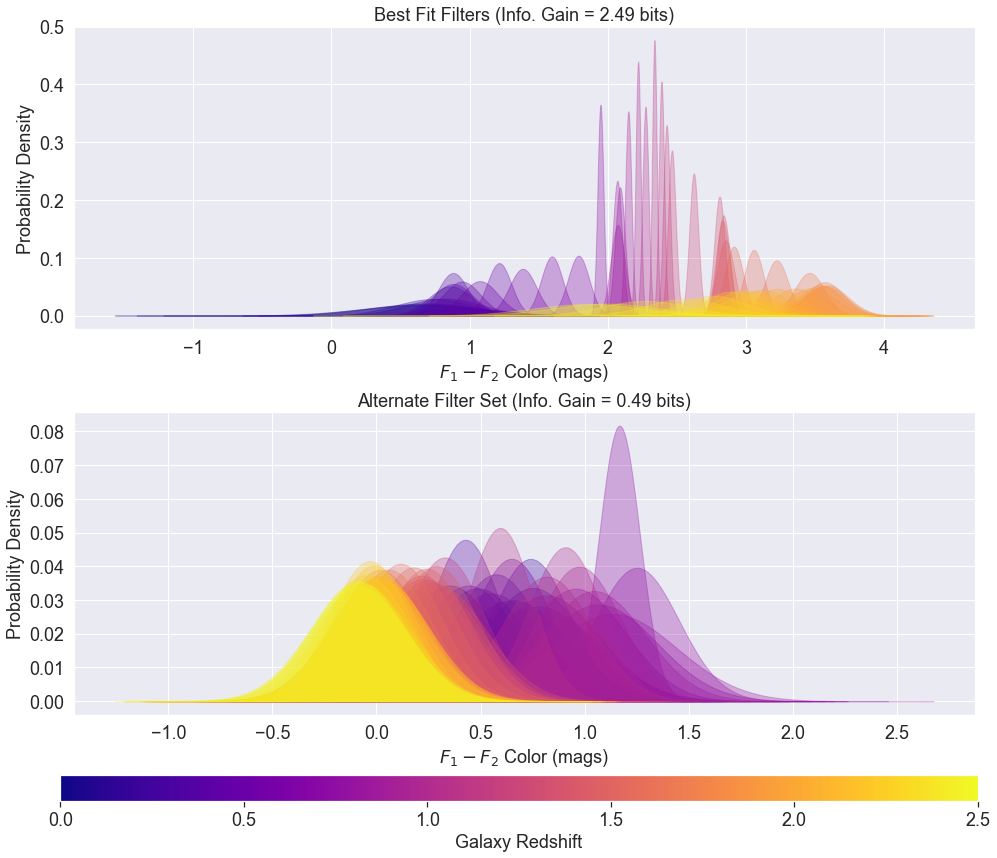

In [39]:
red_spec = s.get_red_spectrum()
fig = plt.figure(figsize=(14, 12))
fig.add_subplot(2,1,1)
sig_plot = plotting([red_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)
col_x, err_x = get_color_color(sig_plot, ['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                       np.linspace(0.05, 2.5, 50), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 50)

i = 0
for c, err, prob_val in zip(col_x, err_x, sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)*.02#*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i]))
    i += 1
plt.title('Best Fit Filters (Info. Gain = 2.49 bits)', size=18)
plt.xlabel(r'$F_{1} - F_{2}$ Color (mags)', size=18)
plt.ylabel('Probability Density', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
    
fig.add_subplot(2,1,2)

sig_plot = plotting([red_spec], [425.0, 525.0, 475.0, 575.0],
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)
col_y, err_y = get_color_color(sig_plot, ['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                       np.linspace(0.05, 2.5, 50), fig=fig, cbar=True)

i=0
for c, err, prob_val in zip(col_y, err_y, sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)*.02#*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3,color=cmap(c_extent[i]))
    i += 1
plt.title('Alternate Filter Set (Info. Gain = 0.49 bits)', size=18)
plt.xlabel(r'$F_{1} - F_{2}$ Color (mags)', size=18)
plt.ylabel('Probability Density', size=18)
plt.xticks(size=18)
plt.yticks(size=18)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
                                       vmin=0.,
                                       vmax=2.5))
sm._A = []

new_ax = fig.add_axes([0.07, 0.06, 0.91, 0.03])

cbar = plt.colorbar(sm, cax=new_ax, orientation='horizontal')
cbar.set_label('Galaxy Redshift', size=18)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.subplots_adjust(bottom = 0.16)
plt.savefig('example_3_color_plot_flat_prior.pdf')

/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


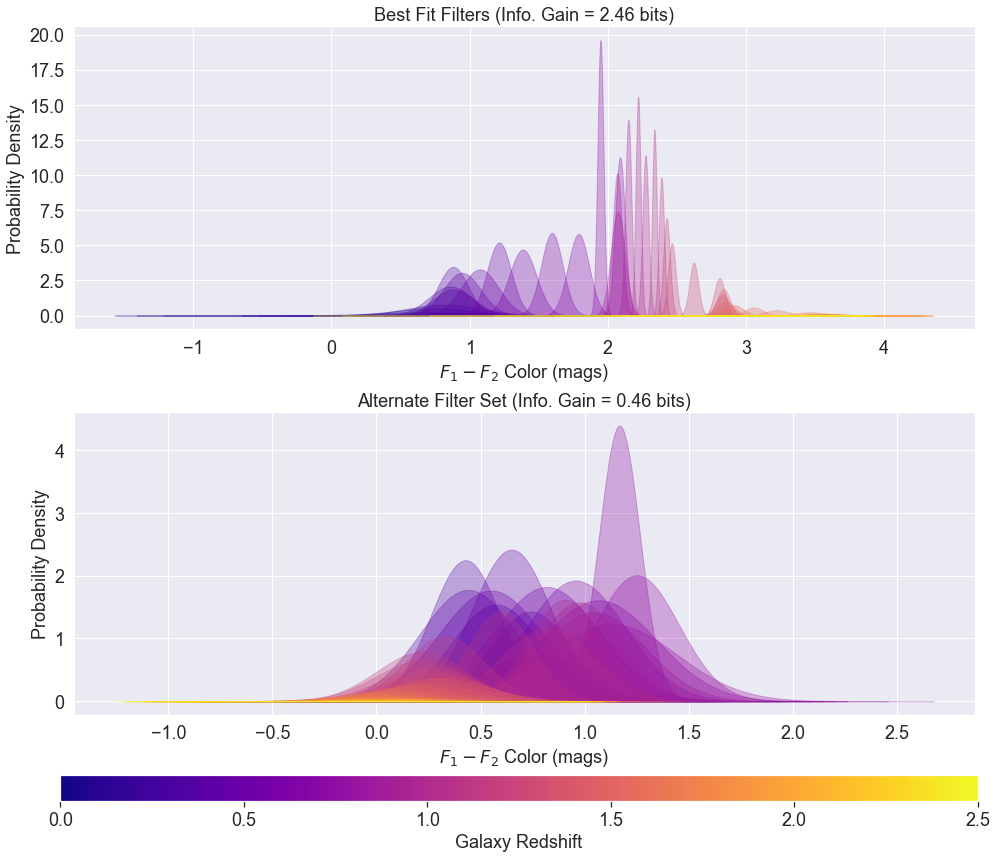

In [40]:
red_spec = s.get_red_spectrum()
fig = plt.figure(figsize=(14, 12))
fig.add_subplot(2,1,1)
sig_plot = plotting([red_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)
col_x, err_x = get_color_color(sig_plot, ['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                       np.linspace(0.05, 2.5, 50), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 50)

i = 0
for c, err, prob_val in zip(col_x, err_x, sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i]))
    i += 1
plt.title('Best Fit Filters (Info. Gain = 2.46 bits)', size=18)
plt.xlabel(r'$F_{1} - F_{2}$ Color (mags)', size=18)
plt.ylabel('Probability Density', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
    
fig.add_subplot(2,1,2)

sig_plot = plotting([red_spec], [425.0, 525.0, 475.0, 575.0],
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)
col_y, err_y = get_color_color(sig_plot, ['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                       np.linspace(0.05, 2.5, 50), fig=fig, cbar=True)

i=0
for c, err, prob_val in zip(col_y, err_y, sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3,color=cmap(c_extent[i]))
    i += 1
plt.title('Alternate Filter Set (Info. Gain = 0.46 bits)', size=18)
plt.xlabel(r'$F_{1} - F_{2}$ Color (mags)', size=18)
plt.ylabel('Probability Density', size=18)
plt.xticks(size=18)
plt.yticks(size=18)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
                                       vmin=0.,
                                       vmax=2.5))
sm._A = []

new_ax = fig.add_axes([0.07, 0.06, 0.91, 0.03])

cbar = plt.colorbar(sm, cax=new_ax, orientation='horizontal')
cbar.set_label('Galaxy Redshift', size=18)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.subplots_adjust(bottom = 0.16)
plt.savefig('example_3_color_plot.pdf')

#### Color-Color Plot of full SED set

In [27]:
def prior_z(z, z0=0.5):
    normalization = 0.08333
    return (z**2.)*np.exp(-(z/z0)**1.5)/normalization

In [28]:
import os
sed_list = []
for sed_name in os.listdir('../siggi/data/cww_kin_lephare/'):
    sed_obj = Sed()
    if sed_name.endswith('.sed'):
        sed_obj.readSED_flambda('../siggi/data/cww_kin_lephare/%s' % sed_name)
        sed_obj.wavelen /= 10.
        sed_list.append(sed_obj)

In [29]:
#import os
#sed_list = []
#for sed_name in os.listdir('../siggi/data/cww_kin_lephare/'):
#    sed_obj = Sed()
#    if sed_name.endswith('.sed'):
#        if sed_name.split('_')[1] in ['SB2', 'SB3', 'SB4', 'SB5']:
#            continue
#        sed_obj.readSED_flambda('../siggi/data/cww_kin_lephare/%s' % sed_name)
#        sed_obj.wavelen /= 10.
#        sed_list.append(sed_obj)

In [30]:
sed_weights = np.ones(len(sed_list))/len(sed_list)

sig_example = siggi(sed_list,
                    sed_weights, prior_z, 
                    z_min=0.05, z_max=2.0, z_steps=40)

In [31]:
lsst_bp_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassDir='../siggi/data/lsst_baseline_throughputs')

In [21]:
colors = []
for sed_obj in sig_example.shift_seds:
    mags = lsst_bp_dict.magListForSed(sed_obj)
    mags = np.array(mags)
    colors.append(mags[1:] - mags[:-1])
    

In [22]:
colors = np.array(colors)

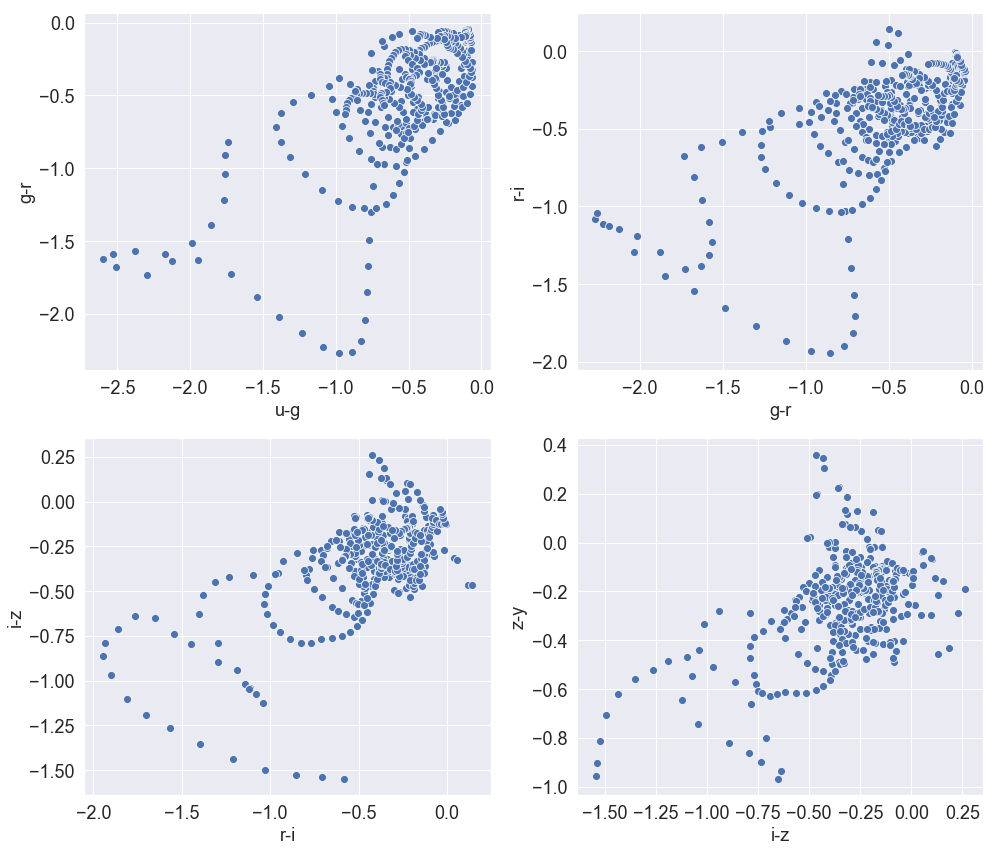

In [51]:
fig = plt.figure(figsize=(14,12))
color_labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']
for i in range(4):
    fig.add_subplot(2,2,i+1)
    sbs.scatterplot(colors[:, i], colors[:, i+1], s=64)
    plt.xlabel(color_labels[i], size=18)
    plt.ylabel(color_labels[i+1], size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.tight_layout()
plt.savefig('color_color.pdf')

## Plot results from full SED runs

#### 6 filters

In [5]:
import os
results_files = [x for x in sorted(os.listdir('results/')) if x.startswith('run_values_ratio')]

In [6]:
points_files = [x for x in sorted(os.listdir('results/')) if x.startswith('run_points_ratio')]

In [7]:
ratio_value = []
max_ig_value = []
points_value = []
for filename_r, filename_p in zip(results_files, points_files):
    ratio_value.append(float(filename_r.split('_')[3][:-4]))
    ig_values = np.genfromtxt(os.path.join('results', filename_r))
    max_ig_value.append(np.max(ig_values))
    ratio_points = np.genfromtxt(os.path.join('results', filename_p))
    points_value.append(ratio_points[np.argmax(ig_values)])

<Figure size 576x432 with 0 Axes>

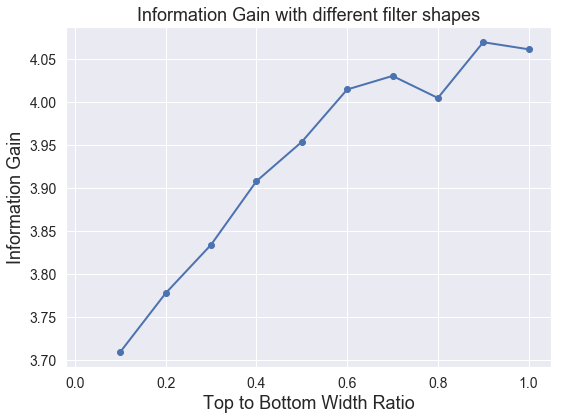

In [13]:
fig = plt.figure(figsize=(8, 6))
plt.figure(figsize=(8,6))
plt.plot(ratio_value, max_ig_value, lw=2, marker='o')
plt.xlabel('Top to Bottom Width Ratio', size=18)
plt.ylabel('Information Gain', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim((-0.02, 1.05))
plt.title('Information Gain with different filter shapes', size=18)
plt.tight_layout()
plt.savefig('ig_6_filters.pdf')

<Figure size 576x432 with 0 Axes>

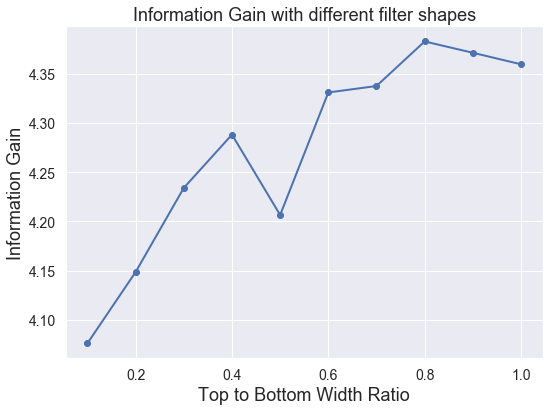

In [105]:
fig = plt.figure(figsize=(8, 6))
plt.figure(figsize=(8,6))
plt.plot(ratio_value, best_values_new, lw=2, marker='o')
plt.xlabel('Top to Bottom Width Ratio', size=18)
plt.ylabel('Information Gain', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Information Gain with different filter shapes', size=18)
plt.tight_layout()
#plt.savefig('ig_6_filters.pdf')

In [14]:
max_ig_value

[3.709257,
 3.777562,
 3.833903,
 3.907808,
 3.953573,
 4.014497,
 4.030287,
 4.004631,
 4.069523,
 4.061267]

In [23]:
points_value

[array([ 300.      ,  437.690352,  300.      ,  554.631151,  450.436853,
         731.059111,  627.004329,  896.725335,  788.488267, 1014.896888,
         889.005595, 1100.      ]),
 array([ 307.223433,  480.778966,  325.06662 ,  630.481923,  525.375584,
         797.502905,  654.083169,  884.611476,  782.047573,  973.386443,
         878.781558, 1100.      ]),
 array([ 300.      ,  436.879464,  328.79505 ,  570.524976,  456.933838,
         735.278074,  590.919694,  901.870884,  778.56432 , 1006.804985,
         906.982507, 1100.      ]),
 array([ 300.      ,  446.073956,  305.467534,  585.083357,  518.661287,
         727.72792 ,  634.13229 ,  884.352295,  776.879952,  977.517481,
         932.641855, 1100.      ]),
 array([ 300.      ,  437.957272,  300.      ,  612.002393,  562.018027,
         789.02182 ,  752.683901,  908.343592,  896.437939, 1007.324211,
         999.63792 , 1100.      ]),
 array([ 300.      ,  427.88386 ,  324.627577,  576.695203,  536.081894,
         767.4169

In [45]:
sig_plot = plotting(sed_list, [308.3879, 461.4850, 425.3143, 582.1540, 568.5341, 718.6256, 684.8183, 857.4177, 830.3135, 963.9340, 945.6139, 1071.1498],
                    frozen_filt_dict=None, set_ratio=1.0,
                    sed_mags=22.0)

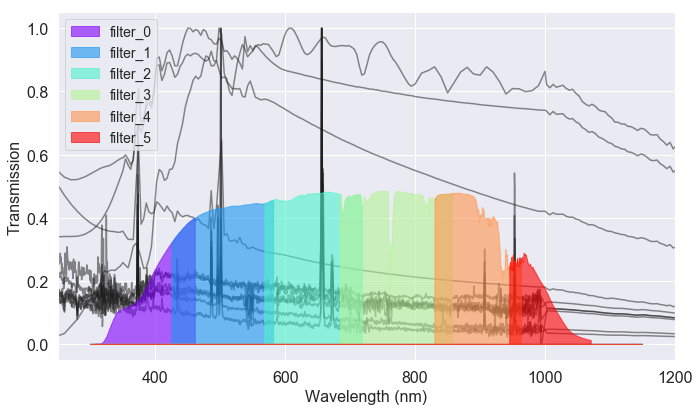

In [46]:
fig = plt.figure(figsize=(10, 6))
sig_plot.plot_filters(fig=fig)
plt.xlabel('Wavelength (nm)', size=16)
plt.xticks(size=16)
plt.ylabel('Transmission', size=16)
plt.yticks(size=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('best_6_filters.pdf')

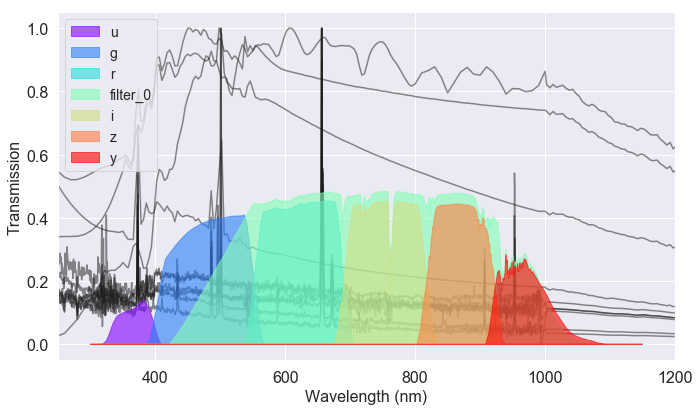

In [38]:
fig = plt.figure(figsize=(10, 6))
sig_plot.plot_filters(fig=fig)
plt.xlabel('Wavelength (nm)', size=16)
plt.xticks(size=16)
plt.ylabel('Transmission', size=16)
plt.yticks(size=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('lsst_plus_one_filter_red.pdf')

In [39]:
best_point = [308.3879, 461.4850, 425.3143, 582.1540, 568.5341, 718.6256, 684.8183, 857.4177, 830.3135, 963.9340, 945.6139, 1071.1498]

In [41]:
filter_info = []
set_ratio = 1.0

for i in range(int(len(best_point)/2)):
    edges = np.array(best_point[2*i:2*(i+1)])
    bottom_len = edges[1] - edges[0]
    top_len = set_ratio*bottom_len
    center = edges[0] + bottom_len/2.
    top_left = center - top_len/2.
    top_right = center + top_len/2.
    filter_info.append([edges[0], top_left, top_right, edges[1]])

In [42]:
f = filters()
bp_6 = f.trap_filters(filter_info)

In [43]:
lsst_vals = ['u', 'g', 'r', 'i', 'z', 'y']
for i in range(6):
    bp_key = 'filter_%i' % i
    bp_6[bp_key].writeThroughput('filter_%s.dat' % lsst_vals[i])

In [33]:
lsst_vals = ['u', 'g', 'r', 'i', 'z', 'y']
for i in range(6):
    bp_key = 'filter_%i' % i
    bp = sig_plot.filter_dict[bp_key]
    bp.wavelen *= 10.
    bp.writeThroughput('lsst_%s.dat' % lsst_vals[i])

KeyError: 'filter_1'

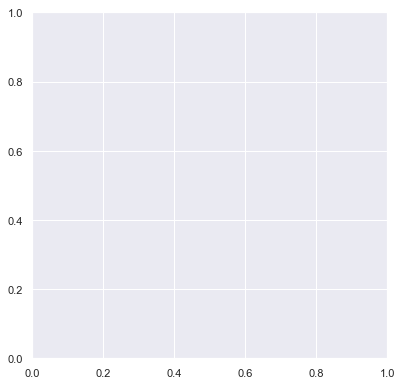

In [44]:
fig = plt.figure(figsize=(14, 14))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    sig_plot.plot_color_color(['filter_%s' % str(i), 
                               'filter_%s' % str(i+1), 
                               'filter_%s' % str(i+1), 
                               'filter_%s' % str(i+2)],
                              np.linspace(0.05, 2.0, 40), fig=fig)
plt.tight_layout()

In [21]:
overlap_edges = np.linspace(300., 1100., 8)
print(overlap_edges)

[ 300.          414.28571429  528.57142857  642.85714286  757.14285714
  871.42857143  985.71428571 1100.        ]


In [22]:
edge_nums = []
for i in range(6):
    edge_nums.append(i)
    edge_nums.append(i+2)

In [23]:
filter_overlap = [overlap_edges[i] for i in edge_nums]

In [24]:
filter_overlap

[300.0,
 528.5714285714286,
 414.2857142857143,
 642.8571428571429,
 528.5714285714286,
 757.1428571428571,
 642.8571428571429,
 871.4285714285714,
 757.1428571428571,
 985.7142857142858,
 871.4285714285714,
 1100.0]

In [30]:
    bp_list = []
    bp_dir = '../siggi/data/lsst_baseline_throughputs'
    for filter_name in ['u', 'g', 'r', 'i', 'z', 'y']:
        current_bp = Bandpass()
        print(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
        current_bp.readThroughput(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
        bp_list.append(current_bp)

../siggi/data/lsst_baseline_throughputs/filter_u.dat
../siggi/data/lsst_baseline_throughputs/filter_g.dat
../siggi/data/lsst_baseline_throughputs/filter_r.dat
../siggi/data/lsst_baseline_throughputs/filter_i.dat
../siggi/data/lsst_baseline_throughputs/filter_z.dat
../siggi/data/lsst_baseline_throughputs/filter_y.dat


In [31]:
new_bp = Bandpass()

In [32]:
new_bp.readThroughput(os.path.join(bp_dir, 'total_r.dat'))

In [38]:
sig_example = siggi(sed_list,
                        np.ones(len(sed_list))/len(sed_list), prior_z, 
                        z_min=0.05, z_max=2.0, z_steps=40)

In [39]:
siggi.ratio = 0.9
siggi.num_filters = 6
siggi.f = filters()
siggi.frozen_filt_dict = None
overlap_dict = sig_example.set_filters(filter_overlap)

In [42]:
rand_state_overlap = np.random.RandomState(1714)

In [41]:
cig = calcIG(overlap_dict, shift_seds, shift_values, ref_filter=new_bp)

In [43]:
# Overlap 10 seds
cig.calc_IG(rand_state=rand_state_overlap)

3.6316726403992803

In [41]:
sig_plot = plotting(sed_list, filter_overlap,
                    frozen_filt_dict=None, set_ratio=0.8,
                    sed_mags=22.0)

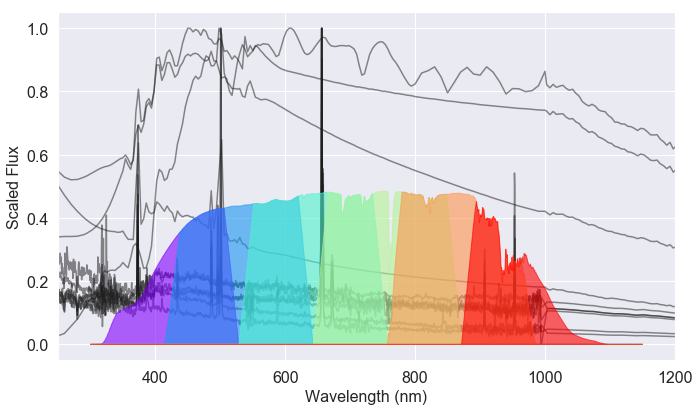

In [83]:
fig = plt.figure(figsize=(10, 6))
sig_plot.plot_filters(fig=fig)
plt.xlabel('Wavelength (nm)', size=16)
plt.xticks(size=16)
plt.ylabel('Scaled Flux', size=16)
plt.yticks(size=16)
plt.tight_layout()
#plt.savefig('best_6_filters.pdf')

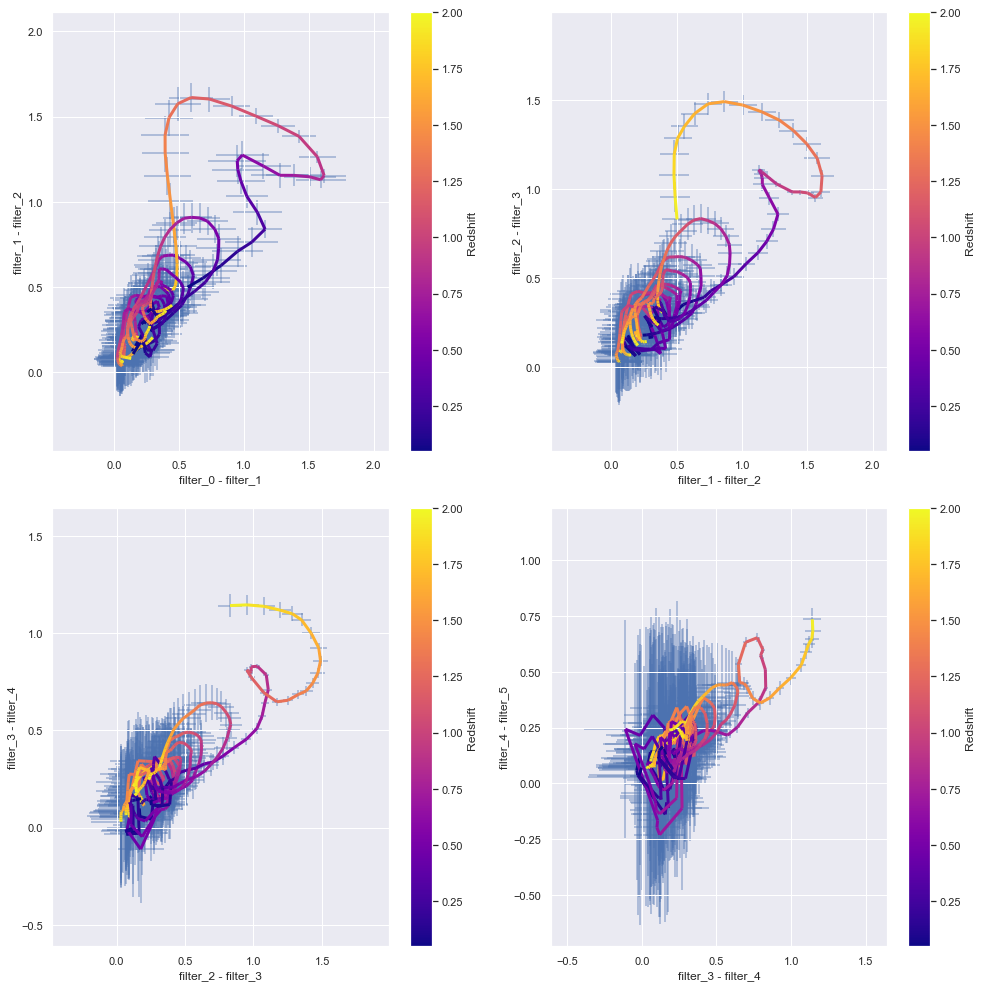

In [84]:
fig = plt.figure(figsize=(14, 14))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    sig_plot.plot_color_color(['filter_%s' % str(i), 
                               'filter_%s' % str(i+1), 
                               'filter_%s' % str(i+1), 
                               'filter_%s' % str(i+2)],
                              np.linspace(0.05, 2.0, 40), fig=fig)
plt.tight_layout()

#### LSST + 1 filter

In [10]:
ig_values_1_filt = np.genfromtxt(os.path.join('results', 'run_values_ff.txt'))
locations_1_filt = np.genfromtxt(os.path.join('results', 'run_points_ff.txt'))

In [11]:
np.max(ig_values_1_filt), locations_1_filt[np.argmax(ig_values_1_filt)]

(2.890584, array([ 300.      ,  327.216643,  738.535318, 1097.838263]))

In [47]:
import os
sed_list = []
for sed_name in os.listdir('../siggi/data/cww_kin_lephare/'):
    sed_obj = Sed()
    if sed_name.endswith('.sed'):
        sed_obj.readSED_flambda('../siggi/data/cww_kin_lephare/%s' % sed_name)
        sed_obj.wavelen /= 10.
        #sed_obj.redshiftSED(0.6)
        #sed_obj.redshiftSED(0.15)
        sed_list.append(sed_obj)

In [4]:
import os
sed_list = []
for sed_name in os.listdir('../siggi/data/cww_kin_lephare/'):
    sed_obj = Sed()
    if sed_name.endswith('.sed'):
        sed_obj.readSED_flambda('../siggi/data/cww_kin_lephare/%s' % sed_name)
        sed_obj.wavelen /= 10.
        sed_obj.redshiftSED(1.5)
        #sed_obj.redshiftSED(0.15)
        sed_list.append(sed_obj)

In [12]:
sed_obj.wavelen[25]

700.0

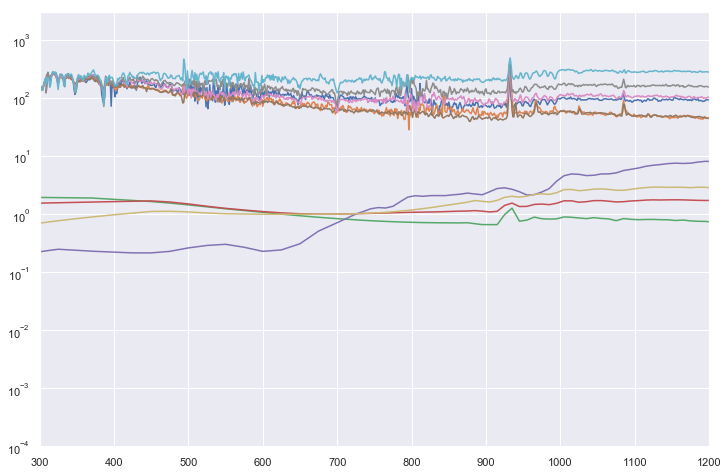

In [14]:
fig = plt.figure(figsize=(12, 8))
for sed_obj in sed_list:
    plt.plot(sed_obj.wavelen, sed_obj.flambda/sed_obj.flambda[25])
plt.xlim(300, 1200)
plt.yscale('log')

In [119]:
sig_plot = plotting(sed_list, locations_1_filt[np.argmax(ig_values_1_filt)],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=22.0)

In [46]:
sig_plot = plotting(sed_list, [300.0000, 300.0000, 787.3689, 1100.0000],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=22.0)

In [41]:
f = filters()
bp_7 = f.trap_filters([985.5970, 1057.5818, 1065.5937, 1077.6576])

In [38]:
f = filters()
bp_7 = f.trap_filters([300.0000, 300.0000, 787.3689, 1100.0000])

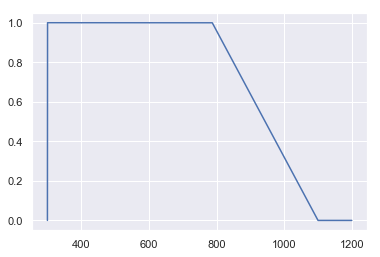

In [33]:
plt.plot(bp_7['filter_0'].wavelen, bp_7['filter_0'].sb)

In [34]:
bp_7['filter_0'].wavelen *= 10.

In [39]:
bp_7['filter_0'].writeThroughput('filter_e_dim.dat')

In [37]:
sig_plot = plotting(sed_list, [421.2960, 550.2440, 986.1850, 1100.0000],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=22.0)

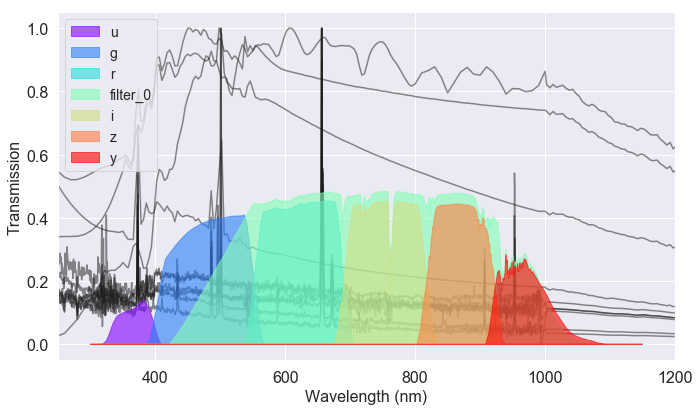

In [38]:
fig = plt.figure(figsize=(10, 6))
sig_plot.plot_filters(fig=fig)
plt.xlabel('Wavelength (nm)', size=16)
plt.xticks(size=16)
plt.ylabel('Transmission', size=16)
plt.yticks(size=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('lsst_plus_one_filter_red.pdf')

In [48]:
for bp_key in ['u', 'g', 'r', 'i', 'z', 'y', 'filter_0']:
    bp = sig_plot.filter_dict[bp_key]
    #bp.wavelen *= 10.
    bp.writeThroughput('lsst_%s.dat' % bp_key)

KeyError: 'u'

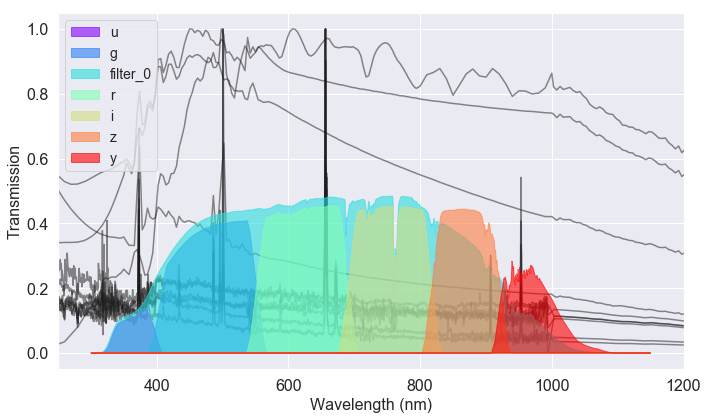

In [48]:
fig = plt.figure(figsize=(10, 6))
sig_plot.plot_filters(fig=fig)
plt.xlabel('Wavelength (nm)', size=16)
plt.xticks(size=16)
plt.ylabel('Transmission', size=16)
plt.yticks(size=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('lsst_plus_one_filter_wide.pdf')

In [88]:
sig_plot = plotting([], np.array([300.0000, 300.0000, 787.3689, 1100.0000, 300.0000, 524.1589, 671.3603, 985.4231, 333.7590861840092, 509.4402805869888, 562.2339266606901, 1044.2544285296403,
                                 985.5969864596755, 1057.581835847035, 1065.5936989437623, 1077.6575611288388]),
                    #frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=22.0)

In [94]:
sig_plot = plotting([], [1045.0629593468811, 1079.367427251621, 1081.8665765381784, 1088.4997576322226],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=22.0)

In [122]:
sig_plot = plotting(sed_list, [1045.0629593468811, 1079.367427251621, 1081.8665765381784, 1088.4997576322226],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=18.0)

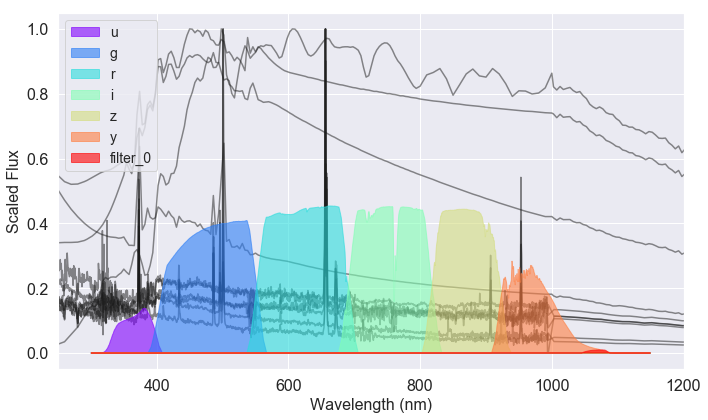

In [123]:
fig = plt.figure(figsize=(10, 6))
#sig_plot.plot_filters(fig=fig)
sig_plot.plot_filters(fig=fig)
#plt.plot(sky_spec.wavelen, sky_spec.flambda/np.max(sky_spec.flambda), label="Dark Sky Spectrum", lw=2, c='k')
plt.xlabel('Wavelength (nm)', size=16)
plt.xticks(size=16)
plt.ylabel('Scaled Flux', size=16)
plt.yticks(size=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('lsst_plus_one_filter_with_sky.pdf')

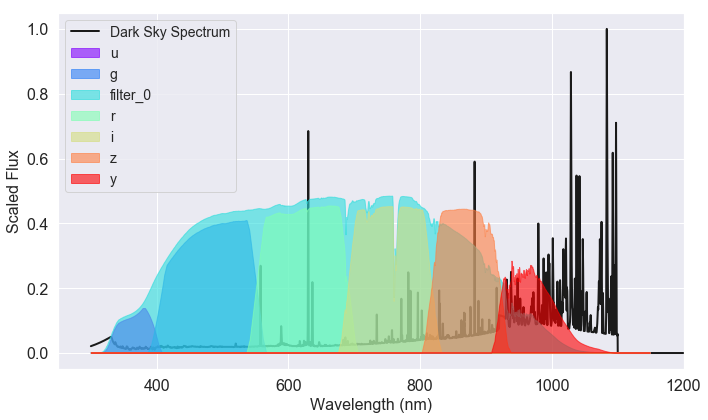

In [76]:
fig = plt.figure(figsize=(10, 6))
sig_plot.plot_filters(fig=fig)
plt.plot(sky_spec.wavelen, sky_spec.flambda/np.max(sky_spec.flambda), label="Dark Sky Spectrum", lw=2, c='k')
plt.xlabel('Wavelength (nm)', size=16)
plt.xticks(size=16)
plt.ylabel('Scaled Flux', size=16)
plt.yticks(size=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('lsst_plus_one_filter_with_sky.pdf')

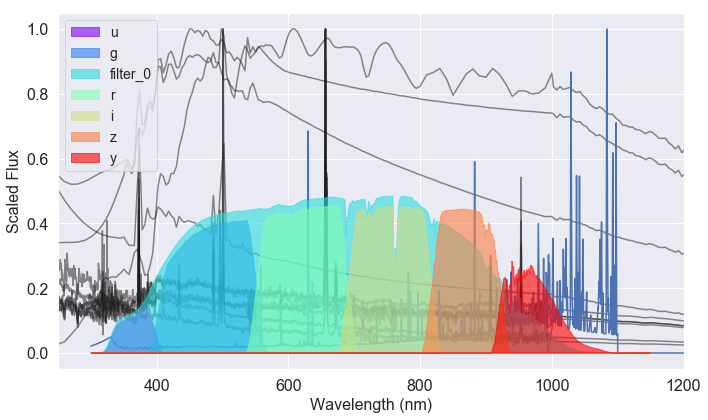

In [66]:
fig = plt.figure(figsize=(10, 6))
sig_plot.plot_filters(fig=fig)
plt.plot(sky_spec.wavelen, sky_spec.flambda/np.max(sky_spec.flambda))
plt.xlabel('Wavelength (nm)', size=16)
plt.xticks(size=16)
plt.ylabel('Scaled Flux', size=16)
plt.yticks(size=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('lsst_plus_one_filter.pdf')

In [14]:
sky_spec = s.get_dark_sky_spectrum()

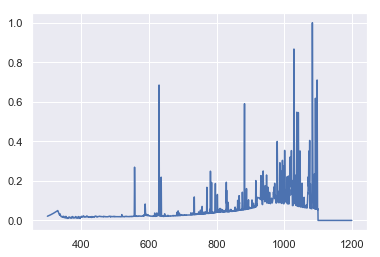

In [77]:
plt.plot(sky_spec.wavelen, sky_spec.flambda/np.max(sky_spec.flambda))

In [27]:
np.where(sky_spec.wavelen >= 450.)

(array([1500, 1501, 1502, ..., 8998, 8999, 9000]),)

In [107]:
sky_spec = s.get_dark_sky_spectrum()

In [25]:
new_sky_spec = np.copy(sky_spec.flambda)
new_sky_spec[2500:] += (sky_spec.wavelen[2500:]-sky_spec.wavelen[2500])*(.2*np.max(sky_spec.flambda)/550.)

In [28]:
new_sky_spec_2 = np.copy(sky_spec.flambda)
new_sky_spec_2[1500:] += (sky_spec.wavelen[1500:]-sky_spec.wavelen[1500])*(.4*np.max(sky_spec.flambda)/650.)

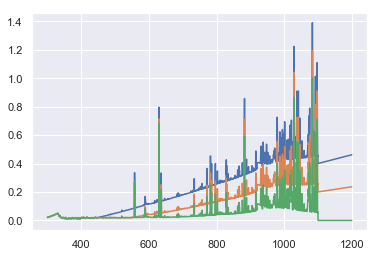

In [29]:
plt.plot(sky_spec.wavelen, new_sky_spec_2/np.max(sky_spec.flambda))
plt.plot(sky_spec.wavelen, new_sky_spec/np.max(sky_spec.flambda))
plt.plot(sky_spec.wavelen, sky_spec.flambda/np.max(sky_spec.flambda))

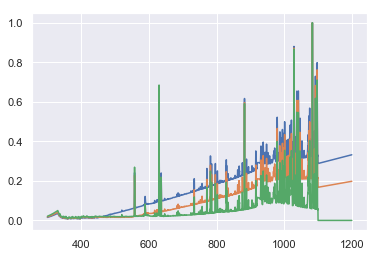

In [30]:
plt.plot(sky_spec.wavelen, new_sky_spec_2/np.max(new_sky_spec_2))
plt.plot(sky_spec.wavelen, new_sky_spec/np.max(new_sky_spec))
plt.plot(sky_spec.wavelen, sky_spec.flambda/np.max(sky_spec.flambda))

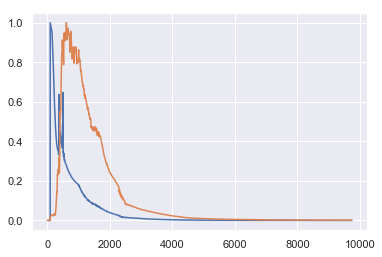

In [144]:
plt.plot(sed_list[2].wavelen, sed_list[2].flambda/np.max(sed_list[2].flambda))
plt.plot(sed_list[4].wavelen, sed_list[4].flambda/np.max(sed_list[4].flambda))

In [151]:
sig_plot = plotting(sed_list, locations_1_filt[np.argmax(ig_values_1_filt)],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=22.0)

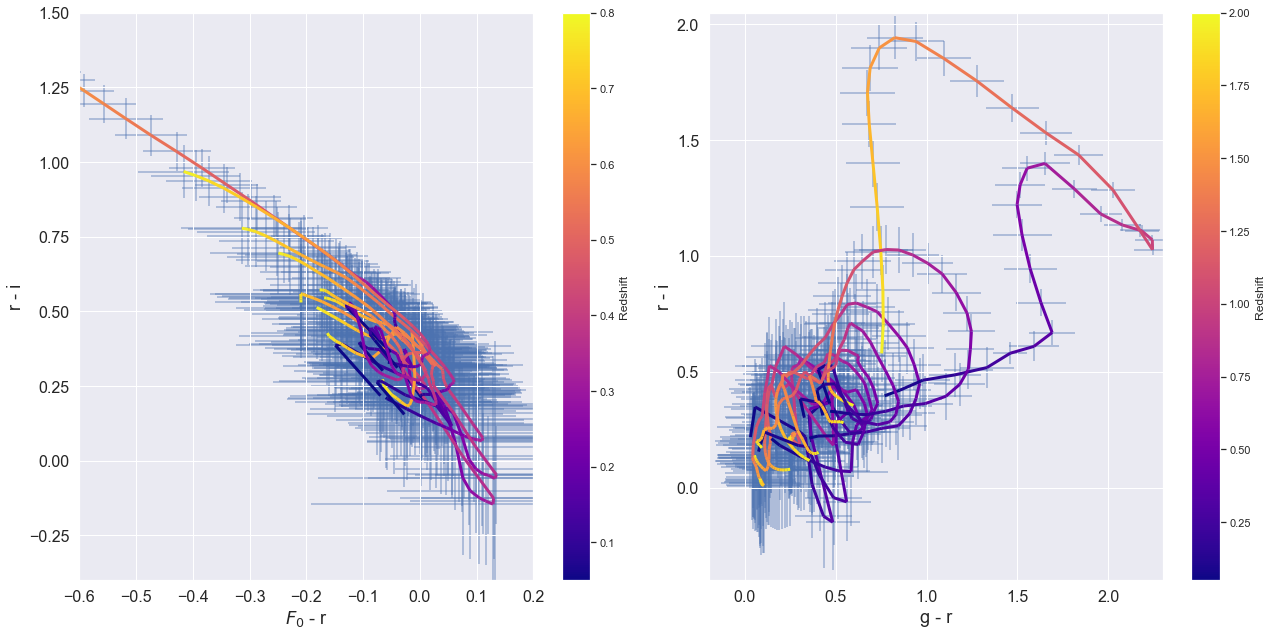

In [61]:
fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1, 2, 1)
#sig_plot.plot_color_color(['filter_0', 'r', 'r', 'i'], np.linspace(0.05, 2.0, 40), fig=fig)
sig_plot.plot_color_color(['filter_0', 'r', 'r', 'i'], np.linspace(0.05, 0.8, 40), fig=fig)
plt.ylabel('r - i', size=18)
plt.xlabel('$F_{0}$ - r', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.xlim(-1.5, 0.3)
plt.xlim(-0.6, 0.2)
#plt.ylim(-0.4, 2.05)
plt.ylim(-0.4, 1.5)
fig.add_subplot(1, 2, 2)
sig_plot.plot_color_color(['g', 'r', 'r', 'i'], np.linspace(0.05, 2.0, 40), fig=fig)
plt.xlabel('g - r', size=18)
plt.ylabel('r - i', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlim(-0.2, 2.3)
plt.ylim(-0.4, 2.05)
plt.tight_layout()
#plt.savefig('1_filter_color_color.pdf')

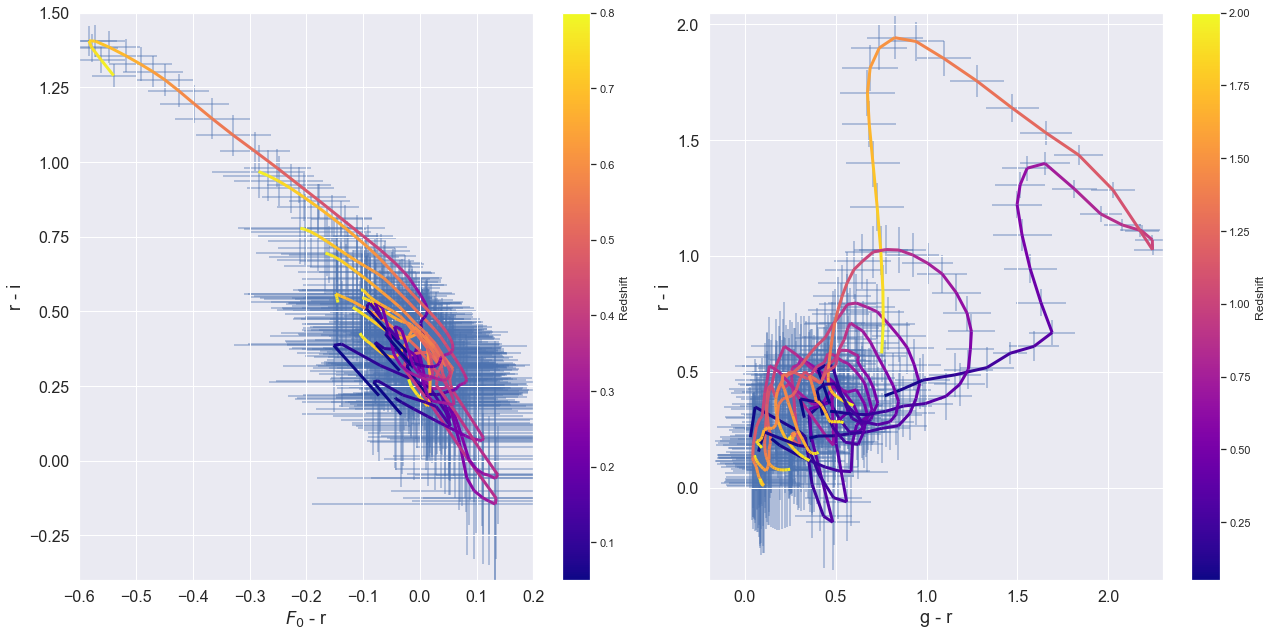

In [58]:
fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1, 2, 1)
#sig_plot.plot_color_color(['filter_0', 'r', 'r', 'i'], np.linspace(0.05, 2.0, 40), fig=fig)
sig_plot.plot_color_color(['filter_0', 'r', 'r', 'i'], np.linspace(0.05, 0.8, 40), fig=fig)
plt.ylabel('r - i', size=18)
plt.xlabel('$F_{0}$ - r', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.xlim(-1.5, 0.3)
plt.xlim(-0.6, 0.2)
#plt.ylim(-0.4, 2.05)
plt.ylim(-0.4, 1.5)
fig.add_subplot(1, 2, 2)
sig_plot.plot_color_color(['g', 'r', 'r', 'i'], np.linspace(0.05, 2.0, 40), fig=fig)
plt.xlabel('g - r', size=18)
plt.ylabel('r - i', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlim(-0.2, 2.3)
plt.ylim(-0.4, 2.05)
plt.tight_layout()
#plt.savefig('1_filter_color_color.pdf')

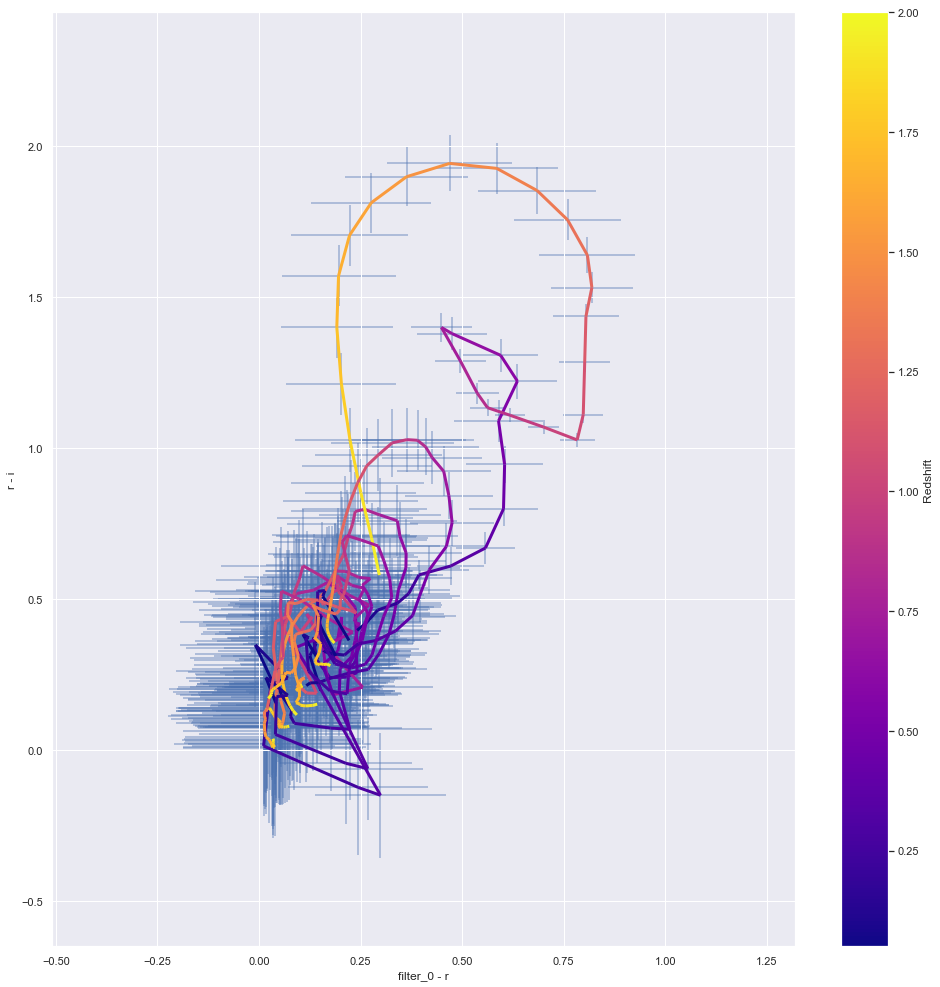

In [160]:
fig = plt.figure(figsize=(14, 14))
sig_plot.plot_color_color(['filter_0', 'r', 'r', 'i'], np.linspace(0.05, 2.0, 40), fig=fig)
plt.tight_layout()

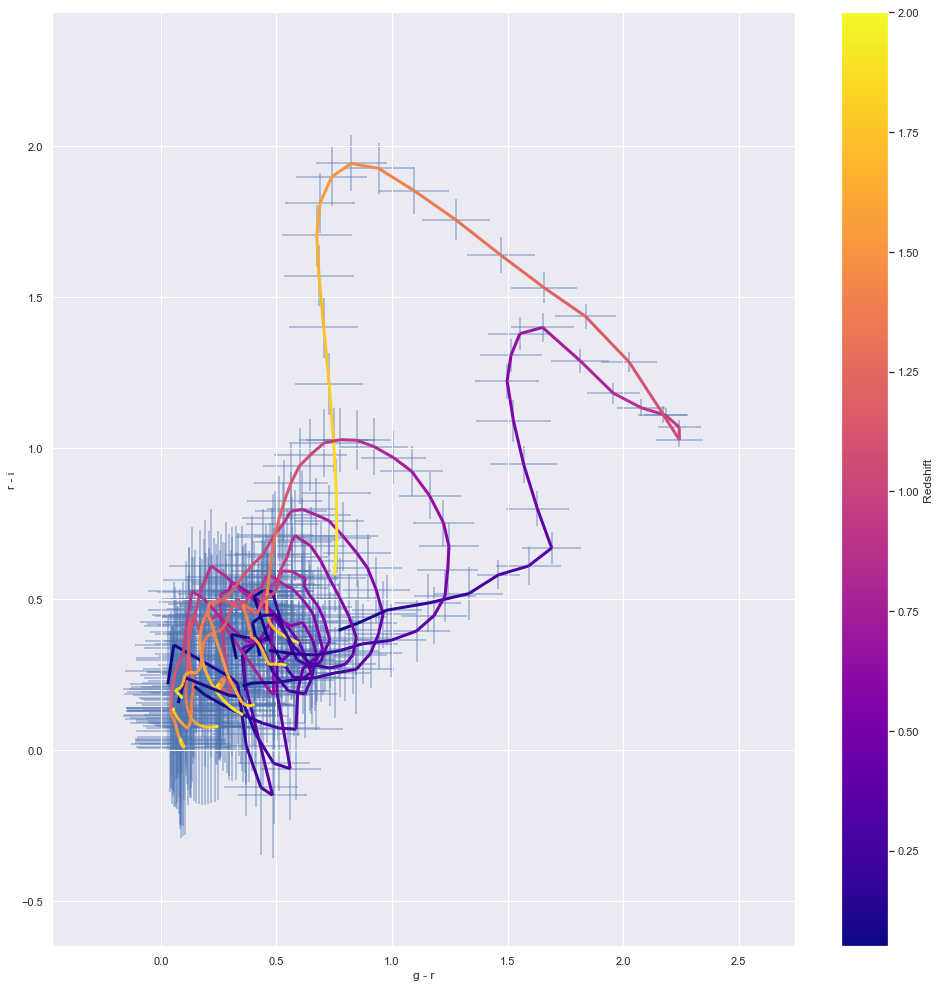

In [120]:
fig = plt.figure(figsize=(14, 14))
sig_plot.plot_color_color(['g', 'r', 'r', 'i'], np.linspace(0.05, 2.0, 40), fig=fig)
plt.tight_layout()

KeyError: 'y'

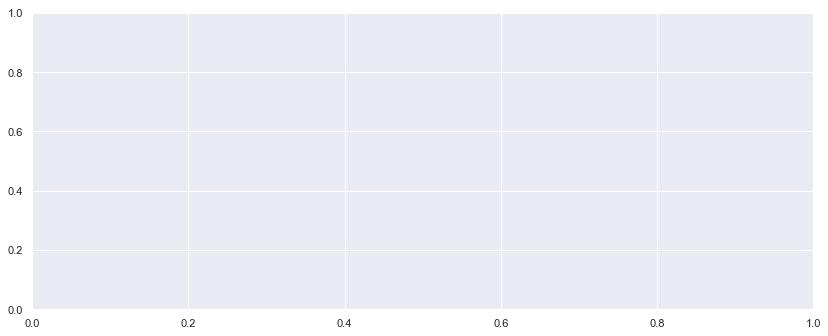

In [108]:
from copy import deepcopy
fig = plt.figure(figsize=(14, 12))
fig.add_subplot(2,1,1)
sed_idx = 4
#sig_plot = plotting([sed_list[sed_idx]], locations_1_filt[np.argmax(ig_values_1_filt)],
sig_plot = plotting([sed_list[sed_idx]], [300.0, 300.0, 806.8914053933313, 1009.4045471032982],
                    sed_mags=22.0)
#col_x, err_x = get_color_color(sig_plot, ['g', 'filter_0', 'g', 'filter_0'],
#                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)
col_x, err_x = get_color_color(sig_plot, ['filter_0', 'y', 'filter_0', 'y'],
                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 40)

i = 0
for c, err in zip(col_x, err_x):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i]))
    i += 1
plt.title('Best Fit Filters (Info. Gain = 1.89 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')
    
fig.add_subplot(2,1,2)

sig_plot = plotting([sed_list[sed_idx]], [300.0, 300.0, 806.8914053933313, 1009.4045471032982],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=22.0)
col_y, err_y = get_color_color(sig_plot, ['z', 'y', 'z', 'y'],
                       np.linspace(0.05, 2.0, 40), fig=fig, cbar=True)

i=0
for c, err in zip(col_y, err_y):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)
    plt.fill_between(pts, 0, vals, alpha=0.3,color=cmap(c_extent[i]))
    i += 1
plt.title('Alternate Filter Set (Info. Gain = 0.43 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
                                       vmin=0.,
                                       vmax=2.0))
sm._A = []

new_ax = fig.add_axes([0.07, 0.06, 0.91, 0.03])

cbar = plt.colorbar(sm, cax=new_ax, label='Galaxy Redshift', orientation='horizontal')

plt.tight_layout()
plt.subplots_adjust(bottom = 0.15)
#plt.savefig('example_3_color_plot.pdf')

/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


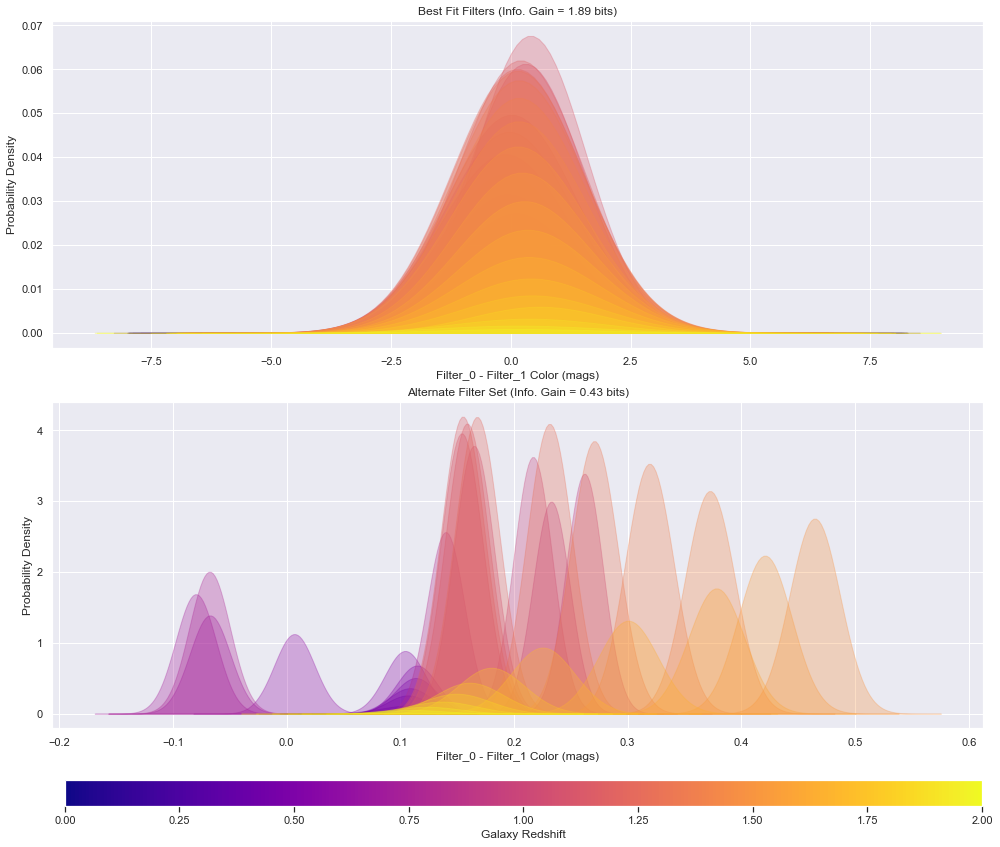

In [117]:
from scipy import stats
from copy import deepcopy
fig = plt.figure(figsize=(14, 12))
fig.add_subplot(2,1,1)
sed_idx = 0
sig_plot = plotting([sed_list[sed_idx]], [1045.0629593468811, 1079.367427251621, 1081.8665765381784, 1088.4997576322226],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=18.0)
col_x, err_x = get_color_color(sig_plot, ['y', 'filter_0', 'y', 'filter_0'],
                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)
#col_x, err_x = get_color_color(sig_plot, ['filter_0', 'r', 'filter_0', 'r'],
#                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 40)

i = 0
for c, err, prob_val in zip(col_x, err_x, 10*sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i]))
    i += 1
plt.title('Best Fit Filters (Info. Gain = 1.89 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')
    
fig.add_subplot(2,1,2)

sig_plot = plotting([sed_list[sed_idx]], [1045.0629593468811, 1079.367427251621, 1081.8665765381784, 1088.4997576322226],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=18.0)
col_y, err_y = get_color_color(sig_plot, ['z', 'y', 'z', 'y'],
                       np.linspace(0.05, 2.0, 40), fig=fig, cbar=True)

i = 0
for c, err, prob_val in zip(col_y, err_y, 10*sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3,color=cmap(c_extent[i]))
    i += 1
plt.title('Alternate Filter Set (Info. Gain = 0.43 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
                                       vmin=0.,
                                       vmax=2.0))
sm._A = []

new_ax = fig.add_axes([0.07, 0.06, 0.91, 0.03])

cbar = plt.colorbar(sm, cax=new_ax, label='Galaxy Redshift', orientation='horizontal')

plt.tight_layout()
plt.subplots_adjust(bottom = 0.15)
#plt.savefig('example_3_color_plot.pdf')

/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


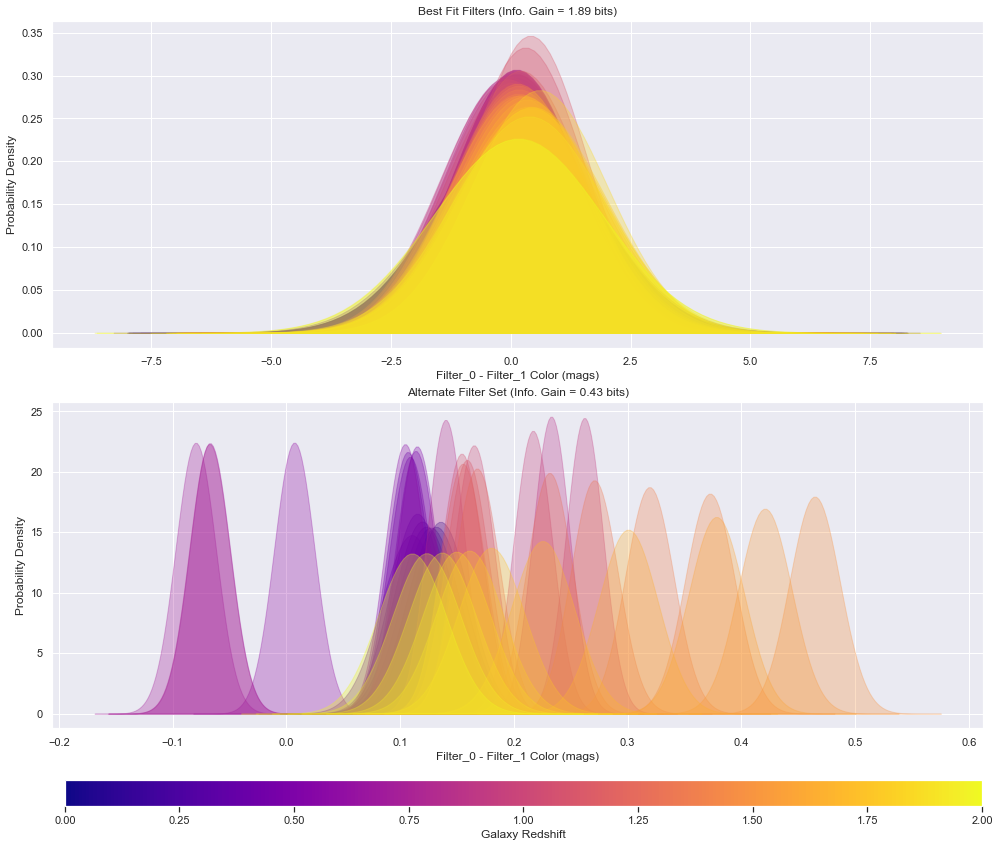

In [118]:
from scipy import stats
from copy import deepcopy
fig = plt.figure(figsize=(14, 12))
fig.add_subplot(2,1,1)
sed_idx = 0
sig_plot = plotting([sed_list[sed_idx]], [1045.0629593468811, 1079.367427251621, 1081.8665765381784, 1088.4997576322226],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=18.0)
col_x, err_x = get_color_color(sig_plot, ['y', 'filter_0', 'y', 'filter_0'],
                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)
#col_x, err_x = get_color_color(sig_plot, ['filter_0', 'r', 'filter_0', 'r'],
#                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 40)

i = 0
for c, err, prob_val in zip(col_x, err_x, 10*sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)#*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i]))
    i += 1
plt.title('Best Fit Filters (Info. Gain = 1.89 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')
    
fig.add_subplot(2,1,2)

sig_plot = plotting([sed_list[sed_idx]], [1045.0629593468811, 1079.367427251621, 1081.8665765381784, 1088.4997576322226],
                    frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=18.0)
col_y, err_y = get_color_color(sig_plot, ['z', 'y', 'z', 'y'],
                       np.linspace(0.05, 2.0, 40), fig=fig, cbar=True)

i = 0
for c, err, prob_val in zip(col_y, err_y, 10*sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)#*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3,color=cmap(c_extent[i]))
    i += 1
plt.title('Alternate Filter Set (Info. Gain = 0.43 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
                                       vmin=0.,
                                       vmax=2.0))
sm._A = []

new_ax = fig.add_axes([0.07, 0.06, 0.91, 0.03])

cbar = plt.colorbar(sm, cax=new_ax, label='Galaxy Redshift', orientation='horizontal')

plt.tight_layout()
plt.subplots_adjust(bottom = 0.15)
#plt.savefig('example_3_color_plot.pdf')

/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


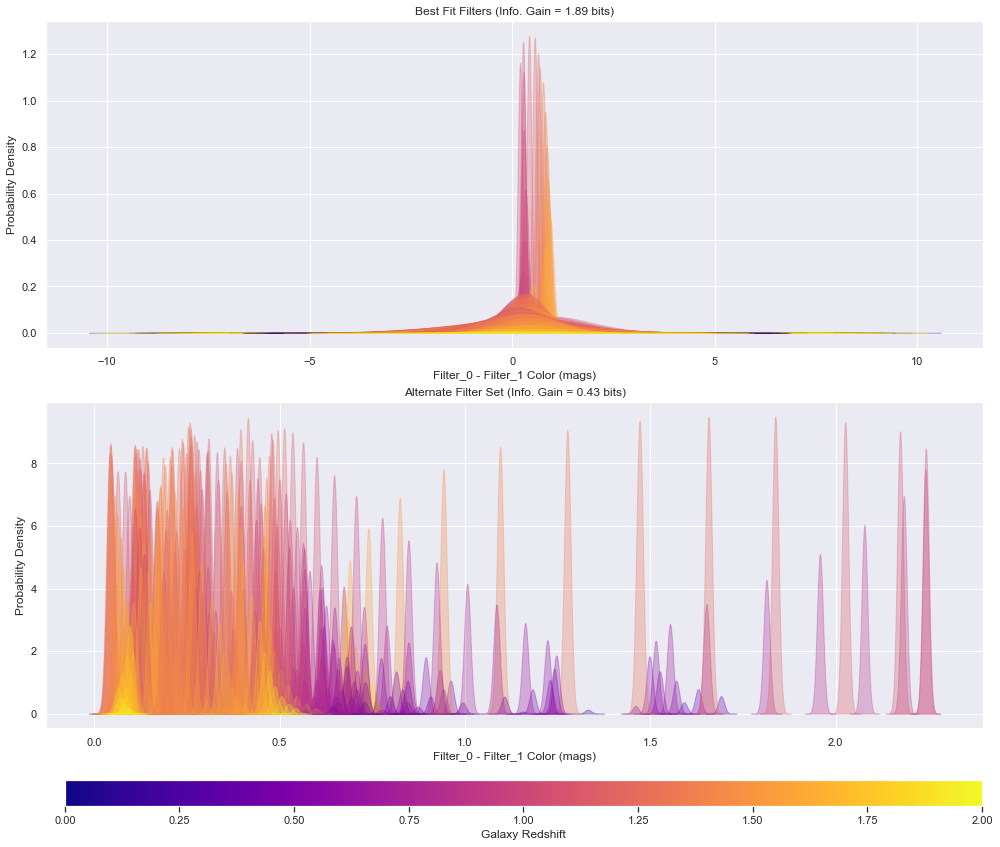

In [128]:
from copy import deepcopy
fig = plt.figure(figsize=(14, 12))
fig.add_subplot(2,1,1)
sed_idx = 0
col_x = []
err_x = []
for sed_idx in range(10):
    sig_plot = plotting([sed_list[sed_idx]], [1045.0629593468811, 1079.367427251621, 1081.8665765381784, 1088.4997576322226], #locations_1_filt[np.argmax(ig_values_1_filt)],
                        frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                        sed_mags=18.0)
    #col_x_1, err_x_1 = get_color_color(sig_plot, ['filter_0', 'r', 'filter_0', 'r'],
    #                       np.linspace(0.4, 0.9, 11), fig=fig, y_label=False)
    col_x_1, err_x_1 = get_color_color(sig_plot, ['y', 'filter_0', 'y', 'filter_0'],
                           np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)
    for c_x, e_x in zip(col_x_1, err_x_1):
        col_x.append(c_x)
        err_x.append(e_x)
#col_x, err_x = get_color_color(sig_plot, ['filter_0', 'r', 'filter_0', 'r'],
#                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 40)

i = 0
for c, err, prob_val in zip(col_x, err_x, 10*sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i % 40]))
    i += 1
plt.title('Best Fit Filters (Info. Gain = 1.89 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')
    
fig.add_subplot(2,1,2)

col_x = []
err_x = []
for sed_idx in range(10):
    sig_plot = plotting([sed_list[sed_idx]], [1045.0629593468811, 1079.367427251621, 1081.8665765381784, 1088.4997576322226], #locations_1_filt[np.argmax(ig_values_1_filt)],
                        frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                        sed_mags=18.0)
    col_x_1, err_x_1 = get_color_color(sig_plot, ['g', 'r', 'g', 'r'],
                           np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)
    for c_x, e_x in zip(col_x_1, err_x_1):
        col_x.append(c_x)
        err_x.append(e_x)
#col_x, err_x = get_color_color(sig_plot, ['filter_0', 'r', 'filter_0', 'r'],
#                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 40)

i = 0
for c, err, prob_val in zip(col_x, err_x, 10*sig_example.z_probs):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i % 40]))
    i += 1
plt.title('Alternate Filter Set (Info. Gain = 0.43 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
                                       vmin=0.,
                                       vmax=2.0))
sm._A = []

new_ax = fig.add_axes([0.07, 0.06, 0.91, 0.03])

cbar = plt.colorbar(sm, cax=new_ax, label='Galaxy Redshift', orientation='horizontal')

plt.tight_layout()
plt.subplots_adjust(bottom = 0.15)
#plt.savefig('example_3_color_plot.pdf')

/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


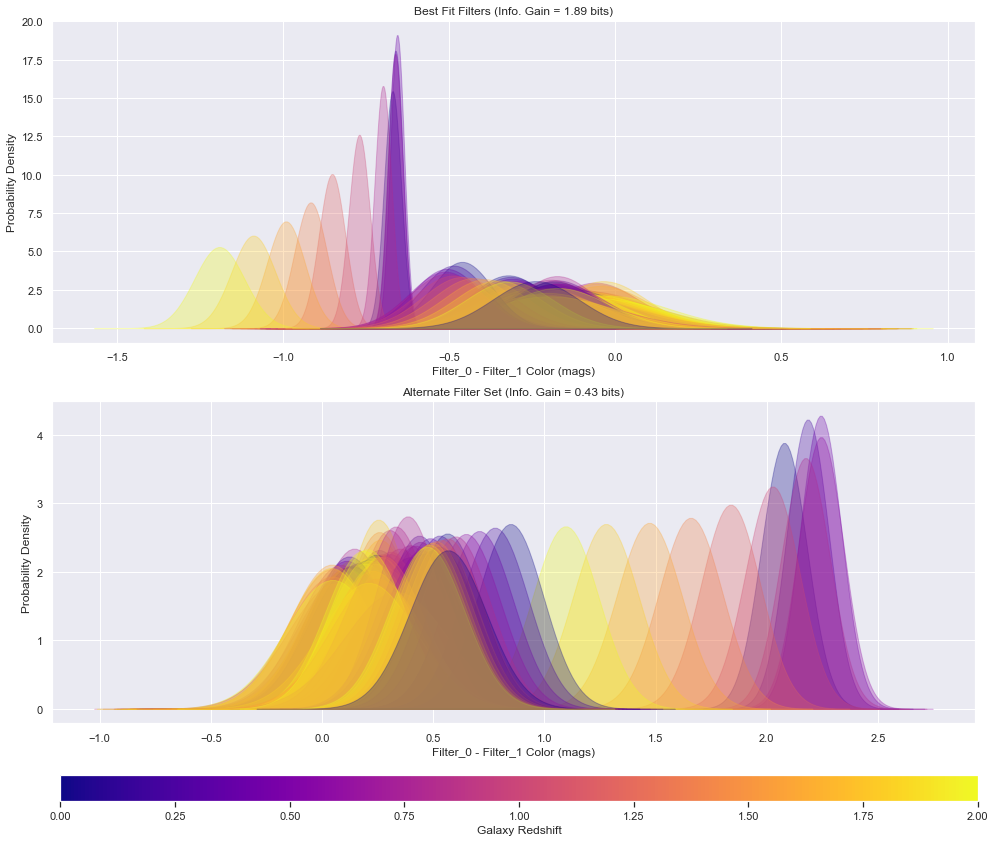

In [157]:
from copy import deepcopy
fig = plt.figure(figsize=(14, 12))
fig.add_subplot(2,1,1)
sed_idx = 0
col_x = []
err_x = []
for sed_idx in range(10):
    sig_plot = plotting([sed_list[sed_idx]], locations_1_filt[np.argmax(ig_values_1_filt)],
                        frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                        sed_mags=22.0)
    col_x_1, err_x_1 = get_color_color(sig_plot, ['filter_0', 'r', 'filter_0', 'r'],
                           np.linspace(0.9, 1.4, 11), fig=fig, y_label=False)
    #col_x_1, err_x_1 = get_color_color(sig_plot, ['g', 'filter_0', 'g', 'filter_0'],
    #                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)
    for c_x, e_x in zip(col_x_1, err_x_1):
        col_x.append(c_x)
        err_x.append(e_x)
#col_x, err_x = get_color_color(sig_plot, ['filter_0', 'r', 'filter_0', 'r'],
#                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 11)

i = 0
for c, err, prob_val in zip(col_x, err_x, 10*sig_example.z_probs[18:28]):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)#*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i % 11]))
    i += 1
plt.title('Best Fit Filters (Info. Gain = 1.89 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')
    
fig.add_subplot(2,1,2)

col_x = []
err_x = []
for sed_idx in range(10):
    sig_plot = plotting([sed_list[sed_idx]], locations_1_filt[np.argmax(ig_values_1_filt)],
                        frozen_filt_dict=lsst_bp_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                        sed_mags=22.0)
    col_x_1, err_x_1 = get_color_color(sig_plot, ['g', 'r', 'g', 'r'],
                           np.linspace(0.9, 1.4, 11), fig=fig, y_label=False)
    for c_x, e_x in zip(col_x_1, err_x_1):
        col_x.append(c_x)
        err_x.append(e_x)
#col_x, err_x = get_color_color(sig_plot, ['filter_0', 'r', 'filter_0', 'r'],
#                       np.linspace(0.05, 2.0, 40), fig=fig, y_label=False)

cmap = plt.get_cmap('plasma')

c_extent = np.linspace(0, 1, 11)

i = 0
for c, err, prob_val in zip(col_x, err_x, 10*sig_example.z_probs[18:28]):
    pts = np.linspace(c-5*err, c+5*err, 100)
    vals = stats.norm.pdf(pts, loc=c, scale=err)#*prob_val
    plt.fill_between(pts, 0, vals, alpha=0.3, color=cmap(c_extent[i % 11]))
    i += 1
plt.title('Alternate Filter Set (Info. Gain = 0.43 bits)')
plt.xlabel('Filter_0 - Filter_1 Color (mags)')
plt.ylabel('Probability Density')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
                                       vmin=0.,
                                       vmax=2.0))
sm._A = []

new_ax = fig.add_axes([0.07, 0.06, 0.91, 0.03])

cbar = plt.colorbar(sm, cax=new_ax, label='Galaxy Redshift', orientation='horizontal')

plt.tight_layout()
plt.subplots_adjust(bottom = 0.15)
#plt.savefig('example_3_color_plot.pdf')

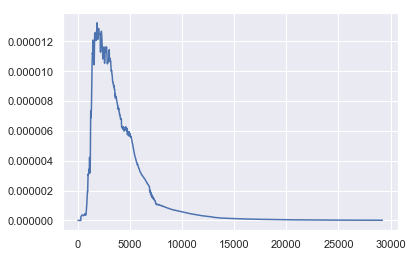

In [54]:
plt.plot(sed_list[4].wavelen*(3), sed_list[4].flambda)

In [86]:
sig_plot.filter_dict['filter_0']

In [54]:
    bp_list = []
    bp_dir = '../siggi/data/lsst_baseline_throughputs'
    for filter_name in ['u', 'g', 'r', 'i', 'z', 'y']:
        current_bp = Bandpass()
        print(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
        current_bp.readThroughput(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
        bp_list.append(current_bp)

../siggi/data/lsst_baseline_throughputs/filter_u.dat
../siggi/data/lsst_baseline_throughputs/filter_g.dat
../siggi/data/lsst_baseline_throughputs/filter_r.dat
../siggi/data/lsst_baseline_throughputs/filter_i.dat
../siggi/data/lsst_baseline_throughputs/filter_z.dat
../siggi/data/lsst_baseline_throughputs/filter_y.dat


In [53]:
bp_list = []
bp_dir = '/astro/store/epyc/users/brycek/siggi/siggi/data/lsst_baseline_throughputs'
for filter_name in ['u', 'g', 'r', 'i', 'z', 'y']:
    current_bp = Bandpass()
    print(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
    current_bp.readThroughput(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
    bp_list.append(current_bp)

/astro/store/epyc/users/brycek/siggi/siggi/data/lsst_baseline_throughputs/filter_u.dat


OSError: The throughput file /astro/store/epyc/users/brycek/siggi/siggi/data/lsst_baseline_throughputs/filter_u.dat does not exist

In [55]:
    frozen_dict = BandpassDict(bp_list, ['u', 'g', 'r', 'i', 'z', 'y'])

In [18]:
new_bp = Bandpass()

In [19]:
new_bp.readThroughput(os.path.join(bp_dir, 'total_r.dat'))

In [90]:
list.insert??

Docstring: L.insert(index, object) -- insert object before index
Type:      method_descriptor


In [71]:
bp_list.insert(2, sig_plot.filter_dict['filter_0'])

In [84]:
bp_list.insert(2, tf)

In [85]:
frozen_dict = BandpassDict(bp_list, ['u', 'g', 'filter_0', 'r', 'i', 'z', 'y'])

In [86]:
frozen_dict.values()

In [11]:
def prior_z(z, z0=0.5):
    normalization = 0.08333
    return (z**2.)*np.exp(-(z/z0)**1.5)/normalization

In [12]:
from copy import deepcopy

In [13]:
redshift_list = np.linspace(0.05, 2.0, 40)
shift_seds = []
shift_values = []

for sed_obj in sed_list:
    for idx, z_val in list(enumerate(redshift_list)):
        sed_copy = deepcopy(sed_obj)
        sed_copy.redshiftSED(z_val)
        shift_seds.append(sed_copy)
        shift_values.append(0.1*prior_z(z_val))

In [56]:
cig = calcIG(frozen_dict, shift_seds, shift_values, ref_filter=new_bp)

In [14]:
cig = calcIG(overlap_dict, shift_seds, shift_values, ref_filter=new_bp)

NameError: name 'overlap_dict' is not defined

In [89]:
cig = calcIG(top_dict, shift_seds, shift_values, ref_filter=new_bp)

In [77]:
# LSST ONLY 6 seds
cig.calc_IG()

4.196830597932658

In [168]:
# LSST Only 10 SEDS
cig.calc_IG()

3.8477557525755355

In [74]:
# 50% Overlap Filters, 10 SEDs
cig.calc_IG()

4.092219094357258

In [90]:
# Best Fit Filters, 10 SEDs
cig.calc_IG()

4.3853513369547015

In [85]:
siggi.ratio = 0.1
siggi.num_filters = 6
siggi.f = filters()
siggi.frozen_filt_dict = None
test_dict = sig_example.set_filters([300.0000, 437.6904, 300.0000, 554.6312, 450.4369, 731.0591,
                                     627.0043, 896.7253, 788.4883, 1014.8969, 889.0056, 1100.0000])

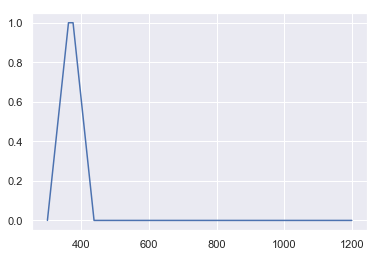

In [88]:
plt.plot(test_dict['filter_0'].wavelen, test_dict['filter_0'].sb)

In [102]:
siggi.ratio = 0.0
siggi.num_filters = 6
siggi.f = filters()
siggi.frozen_filt_dict = None
best_values_new = []
for pv_set in points_value:
    siggi.ratio += 0.1
    siggi.f = filters()
    best_value_dict = sig_example.set_filters(pv_set)
    cig = calcIG(best_value_dict, shift_seds, shift_values, ref_filter=new_bp)
    best_values_new.append(cig.calc_IG())
    print(siggi.ratio, best_values_new[-1])

0.1 4.076199842870162
0.2 4.148626231824458
0.30000000000000004 4.234089870841057
0.4 4.288201744753302
0.5 4.206504216108208
0.6 4.331053799643198
0.7 4.337600360773866
0.7999999999999999 4.382896922164543
0.8999999999999999 4.371404374537294
0.9999999999999999 4.359710685445295


In [107]:
find_tolerance = []
for i in range(50):
    if i % 10 == 0:
        print(i)
    cig = calcIG(best_value_dict, shift_seds, shift_values, ref_filter=new_bp)
    find_tolerancae.append(cig.calc_IG())

0
10
20
30
40


In [111]:
np.mean(find_tolerance), np.std(find_tolerance), np.ptp(find_tolerance)

(4.360991261280195, 0.0012700211579917365, 0.005866137871121779)

(array([ 2.,  6.,  6., 10., 10.,  5.,  7.,  1.,  1.,  2.]),
 array([4.35847313, 4.35905974, 4.35964636, 4.36023297, 4.36081958,
        4.3614062 , 4.36199281, 4.36257942, 4.36316604, 4.36375265,
        4.36433927]),
 <a list of 10 Patch objects>)

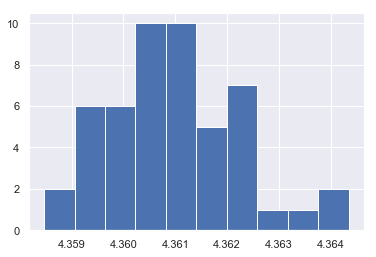

In [112]:
plt.hist(find_tolerance)

In [103]:
cig.calc_h()

7.371564791264772

In [19]:
np.sum(shift_values)

19.948126282411728

In [51]:
sig_example = siggi(sed_list,
                        np.ones(len(sed_list))/len(sed_list), prior_z, 
                        z_min=0.05, z_max=2.0, z_steps=40)

In [17]:
plt.plot(new_bp.wavelen, new_bp.sb)

NameError: name 'new_bp' is not defined

In [18]:
sig_example.z_probs[:5]

[0.0029067322523103198,
 0.010973726672353502,
 0.022909693078788155,
 0.03727261217451664,
 0.052666244249261945]

In [19]:
shift_values[:5]

[0.0029067322523103198,
 0.010973726672353502,
 0.022909693078788155,
 0.03727261217451664,
 0.052666244249261945]

In [61]:
cig_example = calcIG(frozen_dict, sig_example.shift_seds, sig_example.z_probs,
                    sky_mag = 19., sed_mags = 19., ref_filter=sig_example.calib_filter)

In [60]:
# LSST Only 10 SEDS, bright r=18.
cig_example.calc_IG()

8.10399652731356

In [62]:
# LSST Only 10 SEDS, bright r=19.
cig_example.calc_IG()

8.077918414310673

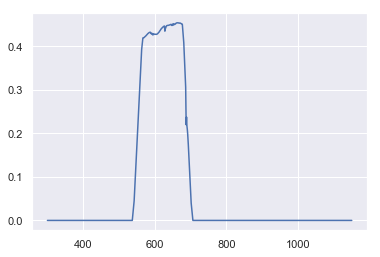

In [186]:
plt.plot(cig_example._total_filt_dict['r'].wavelen, cig_example._total_filt_dict['r'].sb)

In [61]:
cig_example.calc_IG()

3.947852835131548

In [191]:
cig.calc_IG()

3.9058229778911047

In [77]:
sig_example.find_filt_centers([416.4266058814461, 607.1659663094165, 638.013733709967, 644.0027845237809])

[573.416443430716]

In [145]:
sig_example.find_filt_centers(locations_1_filt[np.argmax(ig_values_1_filt)])

[615.897556]

In [16]:
sig_example = siggi(sed_list,
                        np.ones(len(sed_list))/len(sed_list), prior_z, 
                        z_min=0.05, z_max=2.0, z_steps=40)

In [20]:
siggi.ratio = 0.9
siggi.num_filters = 6
siggi.f = filters()
siggi.frozen_filt_dict = None
overlap_dict = sig_example.set_filters(filter_overlap)

NameError: name 'filter_overlap' is not defined

In [88]:
siggi.ratio = 0.8
siggi.num_filters = 6
siggi.f = filters()
siggi.frozen_filt_dict = None
top_dict = sig_example.set_filters([304.0170, 464.1601, 396.2198, 621.8937,
                               585.2629, 760.4970, 720.6744, 865.4516,
                               846.2997, 1027.9448, 954.5521, 1098.2418])

In [ ]:
tf = f.trap_filters

In [81]:
tf

In [53]:
def prior_z(z, z0=0.08):
    normalization = 0.001023
    return (z**2.)*np.exp(-(z/z0)**1.)/normalization

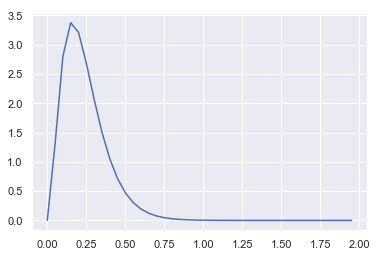

In [54]:
plt.plot(np.arange(0, 2.0, 0.05), prior_z(np.arange(0, 2.0, 0.05)))

In [37]:
def prior_z(z, z0=0.1):
    normalization = 0.08333
    return (z**2.)*np.exp(-(z/z0)**1.5)/normalization

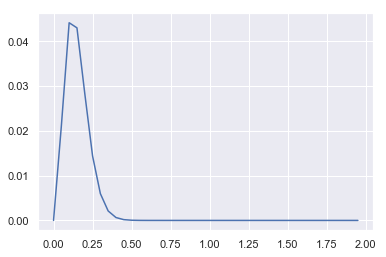

In [38]:
plt.plot(np.arange(0, 2.0, 0.05), prior_z(np.arange(0, 2.0, 0.05)))

In [34]:
np.sum(prior_z(np.arange(0, 2.0, 0.005)))*.005

1.0009774486431162

In [80]:
def prior_z(z, z0=1.4):
    normalization = 0.8931
    return (z**3.)*np.exp(-(z/z0)**5)/normalization

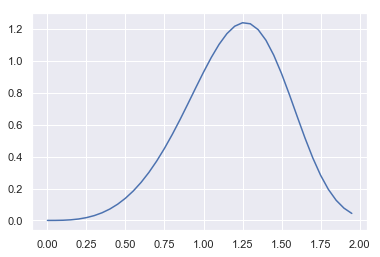

In [81]:
plt.plot(np.arange(0, 2.0, 0.05), prior_z(np.arange(0, 2.0, 0.05)))

In [73]:
np.sum(prior_z(np.arange(0, 2.0, 0.005)))*.005

0.9999850245174873